# Desafio final

Este projeto tem como objetivo realizar uma análise abrangente do consumo de energia elétrica no Brasil, utilizando dados de 2004 a 2023. O desafio consiste em explorar padrões de consumo energético, identificar tendências ao longo do tempo e investigar possíveis correlações com fatores socioeconômicos e geográficos. Através de técnicas de análise exploratória de dados e visualizações informativas, buscaremos compreender as variações no consumo entre diferentes estados, regiões e tipos de consumidores. Além disso, examinaremos a influência de fatores como população e desenvolvimento econômico no consumo de energia. Esta análise visa fornecer insights valiosos sobre o panorama energético brasileiro, contribuindo para uma compreensão mais profunda dos padrões de consumo e potencialmente auxiliando na formulação de políticas energéticas mais eficientes e sustentáveis. Para transparência, esse desafio foi feito de forma colaborativa com inteligência artificial em questões de estrutura e estilos claros e concisos da linguagem Python, buscando sempre que possível o pep-8.

In [265]:
# para começar com o pé direito
print('Hello, world!')

Hello, world!


## Estrutura de arquivos

Antes de mergulharmos na análise do consumo energético brasileiro, é crucial estabelecer uma base sólida para nosso projeto. Uma estrutura organizada e um sistema de versionamento eficiente são fundamentais para garantir a integridade e reprodutibilidade do nosso trabalho.

Para este projeto, adotei a seguinte estrutura de diretórios:

![Estrutura de diretórios e arquivos](../imagens/estrutura_inicio.png)

Esta organização permite uma clara separação entre dados brutos, processados e o código de análise, facilitando a navegação e manutenção do projeto.

Além disso, utilizo o GitHub para controle de versão, o que não só previne perdas acidentais, mas também abre portas para colaborações futuras. Um arquivo `.gitignore` foi configurado para excluir a pasta do ambiente virtual do versionamento, mantendo nosso repositório enxuto e focado apenas nos elementos essenciais do projeto.

Com esta base estabelecida, estamos prontos para iniciar nossa análise do consumo energético no Brasil, assegurando que nosso trabalho seja organizado, rastreável e colaborativo.

## Bibliotecas usadas

In [266]:
# análise e manipulação de dataframes
import pandas as pd
# geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# formatação numérica
import locale

## Preparação

### Criação dos dataframes iniciais

Para importar os dataframes, vamos dar uma breve olhada nos arquivos. Para isso vou abrir o arquivo csv no próprio VS Code, para saber qual é o separador:

![visualização do arquivo csv](../imagens/qual_separador.png)

Podemos ver que o separador é vírgula e que há arquivos ausentes já que tem duas vígulas na sequencia nos primeiros dados.

Agora usando a extensão DataWrangler:

![Visualização do CSV pelo DataWangler](../imagens/entendo_dataset_dw.png)

Podemos ver que em consumidores temos quase 1/3 de dados ausentes (Antes de verificarmos dados duplicados), isso é importante na nossa análise, voltaremos a isso logo mais.

### Importando os dados de energia elétrica

In [267]:
# importando o dataset de energia com o seperador por vírgulas
dataset_energia =  pd.read_csv('../dados/brutos/consumo_energia_eletrica.csv', sep=',', encoding='utf-8')

### Análise de dados duplicados para energia elétrica

Vamos verificar se temos dados duplicados, podemos usar duplicated().sum() e obter a quantidade, mas é interessantes podemos olhar de perto essas duplicatas e termos a certeza de que de fato são duplicatas. Minha abordagem será colocar esses valores em sequência, o dado original seguido do dado duplicado, mas como podem ser muitos dados, vamos adicionar um parâmetro para a escolha de visualização resumida ou completa.

In [268]:
def identifica_duplicatas(dataframe, resumido=True):
    """
    Identifica e exibe as linhas duplicadas em um DataFrame.
    
    Args:
    dataframe (pd.DataFrame): O DataFrame a ser analisado.
    resumido (bool): Se True, exibe um resumo padrão. Se False, exibe todas as linhas duplicadas agrupadas.
    
    Returns:
    pd.DataFrame: DataFrame contendo as linhas duplicadas.
    """
    # Vamos identificar todas as linhas duplicadas. Aqui, 'keep=False' nos ajuda a ver todos os registros repetidos.
    duplicados = dataframe[dataframe.duplicated(keep=False)]

    # Vamos ordenar as duplicatas para que as linhas idênticas fiquem agrupadas
    duplicados_ordenados = duplicados.sort_values(by=dataframe.columns.tolist())

    if resumido:
        # Se a visualização resumida for escolhida, mostramos apenas um resumo com a contagem de duplicatas
        quantidade_duplicados = dataframe.duplicated().sum()
        print(f'Encontramos {quantidade_duplicados} duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.')
        print("-" * 80)  # Linha separadora para facilitar a leitura
        print(duplicados_ordenados)
    else:
        # Aqui, ajustamos as configurações do pandas para mostrar todas as colunas e linhas sem truncamento
        with pd.option_context('display.max_columns', None, 'display.width', None):
            # Vamos agrupar as linhas duplicadas para uma análise mais detalhada
            grupos = duplicados_ordenados.groupby(duplicados_ordenados.columns.tolist())
            
            for _, grupo in grupos:
                print("Aqui está um grupo de linhas duplicadas:")
                for index, row in grupo.iterrows():
                    print(f"Linha {index}:")
                    print(row.to_frame().T)  # Transformamos a série em um DataFrame de uma linha para clareza
                print("-" * 80)  # Linha separadora entre grupos para uma melhor organização visual
                print()  # Linha em branco para separar grupos

In [269]:
identifica_duplicatas(dataset_energia, True)

Encontramos 1017 duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.
--------------------------------------------------------------------------------
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
37912  2023    1       AC    Comercial              23174.0    21629
38929  2023    1       AC    Comercial              23174.0    21629
38247  2023    1       AC   Industrial                299.0     3803
39264  2023    1       AC   Industrial                299.0     3803
38574  2023    1       AC  Residencial             240560.0    47887
...     ...  ...      ...          ...                  ...      ...
39550  2023   12       TO   Industrial               1413.0    35417
37888  2023   12       TO       Outros              53923.0    51090
38905  2023   12       TO       Outros              53923.0    51090
38856  2023   12       TO  Residencial             576079.0   119941
39873  2023   12       TO  Residencial             576079.0  

Temos 1017 duplicatas, e a função mostram que realmente são dados duplicados. Vamos então limpar o dataset.

In [270]:
# removendo as duplicatas
dataset_energia.drop_duplicates(keep='first', inplace=True)

In [271]:
# vamos chamar a função novamente para ver se realmente foi efetivo
identifica_duplicatas(dataset_energia, True)

Encontramos 0 duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [ano, mes, sigla_uf, tipo_consumo, numero_consumidores, consumo]
Index: []


### Criação de funções para detalhes em gráficos

In [272]:
# remove as bordas para uma estética minimalista
def remove_bordas():
  for spine in ax.spines.values():
    spine.set_visible(False)

In [273]:
# ajusta os ticks
def tick_params():
  ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
  ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

### Análise de dados ausentes para energia elétrica

Vamos criar uma função que verifica a quantidade de dados ausentes para as colunas desse dataframe, com base nos resultados que obtivermos, vamos decidir qual abordagem tomar.

In [274]:
def analise_dados_ausentes(df, crescente=False, tamanho_figura=(10, 6)):
    """
    Analisa e visualiza dados ausentes em um DataFrame.

    Args:
    df (pd.DataFrame): O DataFrame a ser analisado.
    crescente (bool): Se True, ordena do menor para o maior. Se False, do maior para o menor.
    tamanho_figura (tuple): Tamanho da figura do gráfico.

    Returns:
    None
    """
    # Vamos calcular a quantidade de valores ausentes para cada coluna
    valores_ausentes = df.isnull().sum().sort_values(ascending=crescente)
    
    # Aqui, calculamos a porcentagem de valores ausentes, o que nos dá uma visão clara da abrangência dos dados ausentes
    porcentagens_ausentes = 100 * df.isnull().sum() / len(df)
    porcentagens_ausentes = porcentagens_ausentes.sort_values(ascending=crescente)

    # Criamos um gráfico de barras horizontal para visualizar os dados ausentes de forma intuitiva
    plt.figure(figsize=tamanho_figura, facecolor='white')
    ax = valores_ausentes.plot(kind='barh', color='#4a4a4a')
    
    # Removemos as bordas desnecessárias para um visual mais limpo
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Ajustamos os ticks para melhorar a legibilidade do gráfico
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    
    # Adicionamos os valores diretamente nas barras para facilitar a interpretação
    for i, v in enumerate(valores_ausentes):
        ax.text(v, i, f' {v}', va='center')
    
    # Definimos títulos e rótulos para contextualizar o gráfico
    plt.title('Quantidade de Dados Ausentes por Coluna', fontsize=14, pad=20)
    plt.xlabel('Número de Dados Ausentes', fontsize=12, labelpad=10)
    plt.ylabel('')  # Optamos por não usar um rótulo no eixo y
    plt.tight_layout()

    # Salvamos o gráfico, permitindo que outros visualizem nossas descobertas facilmente
    plt.savefig('../imagens/quantidade_dados_ausentes.png', format='png', dpi=300)
    plt.show()

    # Agora, imprimimos as porcentagens de dados ausentes para uma rápida revisão
    print("\nPorcentagem de Dados Ausentes por Coluna:")
    for col, porcentagem in porcentagens_ausentes.items():
        print(f"{col}: {porcentagem:.2f}%")

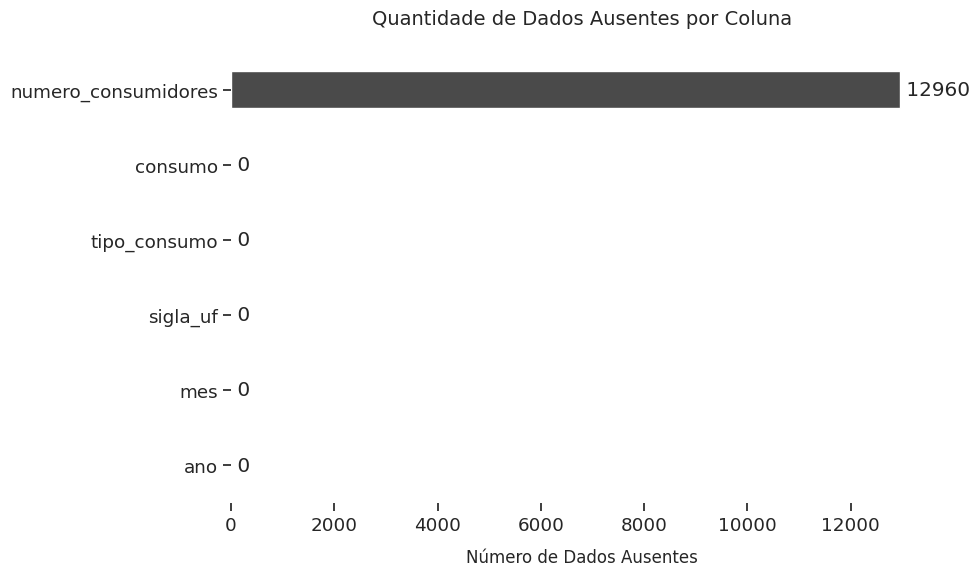


Porcentagem de Dados Ausentes por Coluna:
ano: 0.00%
mes: 0.00%
sigla_uf: 0.00%
tipo_consumo: 0.00%
consumo: 0.00%
numero_consumidores: 33.33%


In [275]:
analise_dados_ausentes(dataset_energia, True)

In [276]:
# Aqui vamos criar um filtro para selecionar só dados em que o número de consumidores seja NaN (nulo ou not a number)
filtro_ausente = dataset_energia['numero_consumidores'].isnull() == True

In [277]:
# usando o filtro
dataset_energia[filtro_ausente]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624
...,...,...,...,...,...,...
37579,2023,12,DF,Cativo,NaN,503565
37580,2023,12,MT,Cativo,NaN,732101
37581,2023,12,RR,Cativo,NaN,112337
37582,2023,12,CE,Cativo,NaN,887204


In [278]:
# Vamos agrupar por ano e contar quantos dados ausentes temos por ano
dataset_energia[filtro_ausente].groupby('ano')['ano'].value_counts()

ano
2004    648
2005    648
2006    648
2007    648
2008    648
2009    648
2010    648
2011    648
2012    648
2013    648
2014    648
2015    648
2016    648
2017    648
2018    648
2019    648
2020    648
2021    648
2022    648
2023    648
Name: count, dtype: int64

Não há concentração de dados ausentes por ano. Cada ano tem exatamente o mesmo valor de dados ausentes. Vamos verificar outras variáveis, como "tipo_consumo".

In [279]:
# Aqui criamos uma variável com os tipos de consumos
tipos = dataset_energia['tipo_consumo'].unique()
# e aqui iteramos sobre a base que contará o total de ausentes em cada um dos tipos que listamos acima
for tipo in tipos:
  print(f'{tipo} = {len(dataset_energia[dataset_energia['tipo_consumo'] == tipo].value_counts())}')

Total = 0
Cativo = 0
Outros = 6480
Comercial = 6480
Industrial = 6480
Residencial = 6480


Total e Cativo não tem valores ao longo de todo o dataframe e eles compoõe os 12960 valores que faltam no dataframe.

Vamos tentar entender o funcionamento desses valores. Podemos inputar valores para Total uma vez que total é a soma de partes? Mas e o Cativo? 

In [280]:
# Criando um filtro para ano, estado e mês específicos
filtro_ano1 = (dataset_energia['ano'] == 2004) & \
              (dataset_energia['sigla_uf'] == 'TO') & \
              (dataset_energia['mes'] == 2)
dataset_energia[filtro_ano1]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
52,2004,2,TO,Total,NaN,63306
356,2004,2,TO,Cativo,NaN,63306
698,2004,2,TO,Outros,22324.0,19893
1025,2004,2,TO,Comercial,26102.0,12160
1333,2004,2,TO,Industrial,2411.0,7267
1654,2004,2,TO,Residencial,233251.0,23986


Nessa amostra podemos perceber que o consumo dos tipos Residencial, Industrial, Comercial e Outros são equivalentes ao Total e que Cativo tem o mesmo valor de Total.

In [281]:
# Criando um segundo filtro para ano, estado e mês específicos
filtro_ano2 = (dataset_energia['ano'] == 2023) & \
              (dataset_energia['sigla_uf'] == 'SP') & \
              (dataset_energia['mes'] == 10)
dataset_energia[filtro_ano2]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
37200,2023,10,SP,Total,NaN,12212694
37509,2023,10,SP,Cativo,NaN,6979373
37849,2023,10,SP,Outros,384492.0,1306374
38158,2023,10,SP,Comercial,1176035.0,2669487
38489,2023,10,SP,Industrial,91621.0,4339535
38799,2023,10,SP,Residencial,19055719.0,3897297


Nessa outra amostra, novamente o consumo dos tipos Residencial, Industrial, Comercial e Outros equivale ao Total, e dessa vez Cativo não tem o mesmo valor, mas é um valor menor. Podemos deduzir que Cativo é uma representação especial que engloba os outros tipos de consumo? Vamos utilizar uma função para ver se é o caso para todo o dataframe.

In [282]:
def verificar_consumo(df, ano, mes, sigla_uf):
    """
    Verifica a consistência dos dados de consumo para um determinado ano, mês e UF.
    
    Args:
    df (pd.DataFrame): O DataFrame com os dados de consumo.
    ano (int): O ano a ser verificado.
    mes (int): O mês a ser verificado.
    sigla_uf (str): A sigla da UF a ser verificada.
    
    Returns:
    dict: Um dicionário com os resultados da verificação.
    """
    # Vamos filtrar o DataFrame para selecionar dados do ano, mês e UF específicos
    filtro = (df['ano'] == ano) & (df['mes'] == mes) & (df['sigla_uf'] == sigla_uf)
    dados_filtrados = df[filtro]
    
    # Coletando o consumo total e cativo para a combinação selecionada
    total = dados_filtrados[dados_filtrados['tipo_consumo'] == 'Total']['consumo'].values[0]
    cativo = dados_filtrados[dados_filtrados['tipo_consumo'] == 'Cativo']['consumo'].values[0]
    
    # Vamos definir os tipos de consumo específicos e calcular a soma deles
    tipos_especificos = ['Outros', 'Comercial', 'Industrial', 'Residencial']
    soma_especificos = dados_filtrados[dados_filtrados['tipo_consumo'].isin(tipos_especificos)]['consumo'].sum()
    
    # Verificações de consistência com uma pequena tolerância para arredondamentos
    soma_igual_total = abs(soma_especificos - total) < 1  # Tolerância de 1 unidade
    cativo_menor_igual_total = cativo <= total
    
    return {
        'ano': ano,
        'mes': mes,
        'sigla_uf': sigla_uf,
        'total': total,
        'soma_especificos': soma_especificos,
        'cativo': cativo,
        'soma_igual_total': soma_igual_total,
        'cativo_menor_igual_total': cativo_menor_igual_total
    }

def verificar_todos_dados(df):
    # Inicializando listas e contadores para armazenar resultados e discrepâncias
    resultados = []
    contador_soma_diferente = 0
    contador_cativo_maior = 0
    
    # Obtendo combinações únicas de ano, mês e UF
    combinacoes = df[['ano', 'mes', 'sigla_uf']].drop_duplicates()
    
    # Vamos iterar sobre cada combinação única para verificar a consistência
    for _, row in combinacoes.iterrows():
        resultado = verificar_consumo(df, row['ano'], row['mes'], row['sigla_uf'])
        
        if not resultado['soma_igual_total']:
            contador_soma_diferente += 1
            print(f"\nDiscrepância na soma (Total vs Específicos):")
            print(f"Ano: {resultado['ano']}, Mês: {resultado['mes']}, UF: {resultado['sigla_uf']}")
            print(f"Total: {resultado['total']}")
            print(f"Soma dos Específicos: {resultado['soma_especificos']}")
            print(f"Diferença: {abs(resultado['total'] - resultado['soma_especificos'])}")
        
        if not resultado['cativo_menor_igual_total']:
            contador_cativo_maior += 1
            print(f"\nCativo maior que Total:")
            print(f"Ano: {resultado['ano']}, Mês: {resultado['mes']}, UF: {resultado['sigla_uf']}")
            print(f"Total: {resultado['total']}")
            print(f"Cativo: {resultado['cativo']}")
            print(f"Diferença: {resultado['cativo'] - resultado['total']}")
        
        resultados.append(resultado)
    
    # Sumário das discrepâncias encontradas
    print(f"\nTotal de discrepâncias na soma: {contador_soma_diferente}")
    print(f"Total de casos onde Cativo > Total: {contador_cativo_maior}")
    
    return pd.DataFrame(resultados)

# Vamos aplicar a função para verificar todos os dados de consumo
df_resultados = verificar_todos_dados(dataset_energia)


Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: TO
Total: 65876
Soma dos Específicos: 65875
Diferença: 1

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: BA
Total: 1444451
Soma dos Específicos: 1444449
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: PR
Total: 1596274
Soma dos Específicos: 1596273
Diferença: 1

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: RS
Total: 1780912
Soma dos Específicos: 1780910
Diferença: 2



Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: SE
Total: 192207
Soma dos Específicos: 192205
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: MG
Total: 3732811
Soma dos Específicos: 3732810
Diferença: 1

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: MS
Total: 272917
Soma dos Específicos: 272915
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: RJ
Total: 2612753
Soma dos Específicos: 2612751
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: PA
Total: 1011353
Soma dos Específicos: 1011351
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: PE
Total: 643102
Soma dos Específicos: 643100
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: RR
Total: 31695
Soma dos Específicos: 31693
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: RN
Total: 268614
Soma dos Espec

A função mostra que há diferenças entre as somas das partes (exceto Cativo) e o Total, mas que essa diferença é na maioria dos casos 1 ou 2 kW e que em três vezes que Cativo foi maior do que o Total a diferença foi de 1kW. Então podemos deduzir o que se mostra a seguir:

1. **Expressão do Consumo Total**:
   $$
   \text{Total} = Residencial + Industrial + Comercial + Outros
   $$

2. **Consumo Cativo como Parte do Total**:
   
   Podemos expressar que o consumo Cativo ($\text{Cativo}$) está contido no Total ($\text{Total}$) da seguinte maneira:
   $$
   \text{Cativo} \subseteq \text{Total}
   $$

3. **Definição Condicional do Consumo Cativo**:
   
   Ou seja:
   $$
   \text{Cativo} = \{ x \in \text{Total} \mid x \text{ representa um consumo que faz parte do regime cativo} \}
   $$


O que é Cativo?

O consumo cativo é um tipo de contratação de energia elétrica em que o consumidor é obrigado a comprar energia de uma concessionária local e pagar as tarifas estabelecidas pelo governo. 
No mercado cativo, o consumidor não pode negociar o preço da energia e está sujeito a cobranças extras, como as bandeiras tarifárias. As tarifas são reguladas pela Agência Nacional de Energia Elétrica (ANEEL) e são estabelecidas considerando os custos de geração, transmissão e distribuição. 
O consumidor cativo é um participante do Ambiente de Contratação Regulada (ACR), que é a forma tradicional de consumir energia no Brasil. A maioria dos consumidores comuns fazem parte do mercado cativo. 
O consumidor cativo pode pagar pela eletricidade por meio de tarifa monômia ou binômia, dependendo de sua classe de tensão. 
O consumidor cativo pode migrar para o mercado livre de energia, desde que comunique a mudança à distribuidora com, no mínimo, seis meses de antecedência.

Fontes: https://srna.co/consumidor-cativo-e-consumidor-livre-entenda-as-diferencas/ https://blog.esferaenergia.com.br/mercado-livre-de-energia/o-que-mercado-cativo-energia https://www.portalsolar.com.br/qual-a-diferenca-entre-consumidor-cativo-e-consumidor-livre-de-energia 

Com base nisso, não excluirei dados, mas segmentarei levando em consideração a ausência de dados em numero_consumidores para Cativos.

In [283]:
# criando uma coluna gWh gigaWatt-hora para ter números menores e mais fáceis de ler
dataset_energia['gWh'] = dataset_energia['consumo'] / 1_000_000

In [284]:
# salvando o dataframe final
dataset_energia.to_csv('../dados/processados/df.csv')

In [285]:
# Criando o dataframe para trabalho usando o copy
df = dataset_energia.copy()

### importando a base de estados

Podemos observar, olhando o arquivo csv que não há dados duplicados, que o separador é ";", mas que temos problemas com o encoding.

![Visualização do CSV da base de estados](../imagens/base_estados.png)

In [286]:
# Importando a base de estados usando encoding latin1 para a acentuação
df_estados = pd.read_csv('../dados/brutos/estado_regiao.csv', sep=';', encoding='latin1')

In [287]:
# Mostrando o começo do df usando head()
df_estados.head()

,id_estado,sigla,estado,regiao,pais
0,1,AC,Acre,Norte,Brasil
1,2,AL,Alagoas,Nordeste,Brasil
2,3,AP,Amapá,Norte,Brasil
3,4,AM,Amazonas,Norte,Brasil
4,5,BA,Bahia,Nordeste,Brasil


Vamos fazer duas intervenções nessa base, como a base de dados de energia usa sigla_uf para identificar os estados, não precisamos da coluna id_estado e como estamos trabalhando apenas com dados do Brasil, não precisamos da coluna país. Vamos então renomear a coluna sigla para sigla_uf e excluir id_estado e pais.

In [288]:
# removendo as colunas
df_estados.drop(['id_estado', 'pais'], axis=1, inplace=True)

# renomeando a coluna para o join
df_estados.rename(columns={'sigla': 'sigla_uf'}, inplace=True)


In [289]:
df_estados.head()

,sigla_uf,estado,regiao
0,AC,Acre,Norte
1,AL,Alagoas,Nordeste
2,AP,Amapá,Norte
3,AM,Amazonas,Norte
4,BA,Bahia,Nordeste


In [290]:
df_estados.to_csv('../dados/processados/df_estados.csv')

In [291]:
df

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,gWh
0,2004,1,TO,Total,NaN,65876,0.065876
1,2004,1,BA,Total,NaN,1444451,1.444451
2,2004,1,PR,Total,NaN,1596274,1.596274
3,2004,1,RS,Total,NaN,1780912,1.780912
4,2004,1,GO,Total,NaN,630624,0.630624
...,...,...,...,...,...,...,...
38875,2023,12,BA,Residencial,5932740.0,718461,0.718461
38876,2023,12,PA,Residencial,2614106.0,478726,0.478726
38877,2023,12,AC,Residencial,245699.0,58301,0.058301
38878,2023,12,RN,Residencial,1390080.0,210119,0.210119


### importando a população de 2000, 2010 e 2022

Os dados de população vieram do IBGE e de diferentes formas, então vamos tratar esses dados.

In [292]:
# importando a base para a população por estados dos anos 2000
pop_2000 = pd.read_excel('../dados/brutos/pop_2000.xls')
pop_2000.head(10)

,"Tabela 2 - População residente, por situação do domicílio e sexo,",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,segundo as Grandes Regiões e as Unidades da Fe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grandes Regiões\ne\nUnidades da Federação,"População residente, por situação do domicílio...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Total ...,NaN,NaN,Urbana ...,NaN,NaN,Rural ...,NaN,NaN
5,NaN,Total ...,Homens ...,Mulheres ...,Total ...,Homens ...,Mulheres ...,Total ...,Homens ...,Mulheres ...
6,Brasil,169799170,83576015,86223155,137953959,66882993,71070966,31845211,16693022,15152189
7,Norte,12900704,6533555,6367149,9014365,4441624,4572741,3886339,2091931,1794408
8,Rondônia,1379787,708140,671647,884523,439714,444809,495264,268426,226838
9,Acre,557526,280983,276543,370267,180190,190077,187259,100793,86466


In [293]:
# Vamos selecionar apenas as linhas de interesse: estados e suas populações
pop_2000 = pop_2000.iloc[6:-2, [0, 1]].copy()

# Aqui, renomeamos as colunas para algo mais significativo
pop_2000.rename(columns={'Tabela 2 - População residente, por situação do domicílio e sexo, ': 'estado',
                         'Unnamed: 1': 'populacao'}, inplace=True)

# Removemos as linhas que contêm dados por região, pois essa informação já está no nosso DataFrame de estados
pop_2000 = pop_2000[pop_2000['estado'].isin(df_estados['estado'])]

# Resetamos o índice para manter o DataFrame organizado após as alterações
pop_2000.reset_index(drop=True, inplace=True)

# Convertendo a coluna 'populacao' para o tipo inteiro para facilitar cálculos futuros
pop_2000['populacao'] = pop_2000['populacao'].astype(int)

# Criamos uma variável que armazena o total da população do Brasil em 2000
pop_2000_brasil = int(pop_2000['populacao'].sum())

In [294]:
# Verificando as duplicatas
identifica_duplicatas(pop_2000, resumido=True)

Encontramos 0 duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [estado, populacao]
Index: []


In [295]:
# Salvando como csv
pop_2000.to_csv('../dados/processados/pop_2000.csv')

In [296]:
pop_2000.head()

,estado,populacao
0,Rondônia,1379787
1,Acre,557526
2,Amazonas,2812557
3,Roraima,324397
4,Pará,6192307


In [297]:
pop_2010 = pd.read_excel('../dados/brutos/pop_2010.xls')
pop_2010.head(10)

,Censo Demográfico 2010 - Resultados Gerais da Amostra,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"Tabela 1.2.1 - População residente, por nacion...",NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Grandes Regiões e Unidades da Federação,População residente,NaN,NaN,NaN,NaN
3,NaN,Total,Nacionalidade,NaN,NaN,NaN
4,NaN,NaN,Brasileira,NaN,NaN,Estrangeira
5,NaN,NaN,Total,Nata,Por naturalização,NaN
6,Brasil,190755799,190324479.672607,190163229.329875,161250.342732,431319.327393
7,Norte,15864454.0,15847999.325467,15838717.080313,9282.245154,16454.674533
8,Rondônia,1562409.0,1559687.35831,1557720.139,1967.219311,2721.64169
9,Acre,733559,732627.464974,732047.54461,579.920364,931.535026


In [298]:
# Vamos isolar as linhas de interesse: estados e suas populações
pop_2010 = pop_2010.iloc[6:-2, [0, 1]]

# Aqui, renomeamos as colunas para algo mais intuitivo
pop_2010.rename(columns={'Censo Demográfico 2010 - Resultados Gerais da Amostra': 'estado',
                         'Unnamed: 1': 'populacao'}, inplace=True)

# Removemos as linhas que contêm dados por região, visto que essas informações já estão presentes no nosso DataFrame de estados
pop_2010 = pop_2010[pop_2010['estado'].isin(df_estados['estado'])]

# Resetamos o índice para reorganizar o DataFrame de acordo com as mudanças feitas
pop_2010.reset_index(drop=True, inplace=True)

# Convertendo a coluna 'populacao' para o tipo inteiro, facilitando assim operações numéricas futuras
pop_2010['populacao'] = pop_2010['populacao'].astype(int)

# Calculamos o total da população do Brasil em 2010 e armazenamos na variável 'pop_2010_brasil'
pop_2010_brasil = int(pop_2010['populacao'].sum())

In [299]:
identifica_duplicatas(pop_2010, resumido=True)

Encontramos 0 duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [estado, populacao]
Index: []


In [300]:
pop_2010.to_csv('../dados/processados/pop_2010.csv')

In [301]:
pop_2010.head(5)

,estado,populacao
0,Rondônia,1562409
1,Acre,733559
2,Amazonas,3483985
3,Roraima,450479
4,Pará,7581050


In [302]:
# Vamos importar a base de dados do censo de 2022
pop_2022 = pd.read_csv('../dados/brutos/Censo_2022_populacao.csv', sep=';', encoding='utf8')

# Aqui, renomeamos as colunas para que os nomes façam mais sentido no contexto da nossa análise
pop_2022.rename(columns={'Unidades da Federação': 'estado', 'pessoas': 'populacao'}, inplace=True)

# Calculamos o total da população brasileira em 2022 e armazenamos na variável 'pop_2022_brasil'
pop_2022_brasil = int(pop_2022['populacao'].sum())

In [303]:
identifica_duplicatas(pop_2022, resumido=True)

Encontramos 0 duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [estado, populacao]
Index: []


In [304]:
pop_2022.to_csv('../dados/processados/pop_2022.csv')

### Importando o IDH entre 2012 e 2021

Índice de Desenvolvimento Humano Municipal  
O IDHM é uma medida resumo que avalia o progresso de longo prazo em três dimensões básicas do desenvolvimento humano: uma vida longa e saudável, o acesso ao conhecimento e um padrão de vida decente. 

Fonte: https://www.undp.org/pt/brazil/desenvolvimento-humano/painel-idhm

In [305]:
idhm = pd.read_excel('../dados/brutos/idhm.xlsx')

In [306]:
# Vamos selecionar apenas os dados de interesse: ano, nome do estado e IDH
idhm = idhm.iloc[10:280, [0, 3, 4]].copy().reset_index(drop=True)

In [307]:
# Vamos renomear as colunas para que coincidam com os demais dataframes e facilite o merge
idhm.rename(columns={'ANO': 'ano', 'NOME': 'estado', 'IDHM': 'idhm'}, inplace=True)

In [308]:
identifica_duplicatas(idhm, resumido=True)

Encontramos 0 duplicatas. Para explorar cada uma delas, mude o parâmetro "resumido" para False.
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [ano, estado, idhm]
Index: []


In [309]:
idhm.to_csv('../dados/processados/idhm.csv')

In [310]:
# Aqui usamos o sample() para verificar os dados, mas poderia ser head() ou tail() também.
idhm.sample(5)

,ano,estado,idhm
55,2014,Acre,0.715
170,2018,Piauí,0.699
152,2017,Espírito Santo,0.780
227,2020,Paraíba,0.714
143,2017,Piauí,0.694


## Funções de gráfico

### Gráfico de linha

Vamos criar uma função `grafico_linha` que permite criar gráficos de linha dinâmicos a partir de um DataFrame, isso vai facilitar a visualização de dados ao longo do tempo. Vamos utilizar parâmetros flexíveis que permitam filtrar dados por ano, mês, estado ou região, escolher entre tipos de consumo e aplicar diferentes agregações, como soma ou média. A função também ajusta automaticamente o layout do gráfico e salva o resultado em um arquivo PNG.

In [428]:
import re

def grafico_linha(dataframe, coluna_y, titulo, rotulo_y, 
                  eixo_x='ano', filtro_x=None, 
                  filtro_estado=None, filtro_regiao=None, 
                  tipo_consumo='total', funcao_agg='soma', 
                  hue=None, tamanho_figura=(12, 6),
                  milhares=False):
    """
    Cria um gráfico de linha dinâmico baseado nos parâmetros fornecidos.
    
    Parâmetros:
    dataframe (DataFrame): O DataFrame contendo os dados.
    coluna_y (str): Nome da coluna para o eixo Y (ex: 'gWh', 'consumo').
    titulo (str): Título do gráfico.
    rotulo_y (str): Rótulo do eixo Y.
    eixo_x (str): 'ano' ou 'mes' para escolher o eixo X.
    filtro_x (list, opcional): Lista de anos ou meses para filtrar.
    filtro_estado (str ou list, opcional): Estado(s) para filtrar.
    filtro_regiao (str ou list, opcional): Região(ões) para filtrar.
    tipo_consumo (str): 'total' ou 'detalhado' para filtrar o tipo de consumo.
    funcao_agg (str): Função de agregação ('soma', 'media', ou 'mediana').
    hue (str, opcional): Nome da coluna para diferenciar múltiplas linhas.
    tamanho_figura (tuple, opcional): Tamanho da figura (largura, altura).
    
    Retorna:
    matplotlib.figure.Figure: O objeto Figure do gráfico criado.
    """

    # Filtrar por tipo de consumo
    if tipo_consumo == 'total':
        dataframe = dataframe[dataframe['tipo_consumo'] == 'Total']
    elif tipo_consumo == 'detalhado':
        dataframe = dataframe[dataframe['tipo_consumo'].isin(['Outros', 'Comercial', 'Industrial', 'Residencial'])]
    else:
        raise ValueError("tipo_consumo deve ser 'total' ou 'detalhado'")
    
    # Aplicar filtros
    if filtro_estado:
        if isinstance(filtro_estado, str):
            dataframe = dataframe[dataframe['estado'] == filtro_estado]
        elif isinstance(filtro_estado, list):
            dataframe = dataframe[dataframe['estado'].isin(filtro_estado)]
    
    if filtro_regiao:
        if isinstance(filtro_regiao, str):
            dataframe = dataframe[dataframe['regiao'] == filtro_regiao]
        elif isinstance(filtro_regiao, list):
            dataframe = dataframe[dataframe['regiao'].isin(filtro_regiao)]
    
    if filtro_x:
        dataframe = dataframe[dataframe[eixo_x].isin(filtro_x)]
    
    # Preparar o agrupamento
    colunas_grupo = [eixo_x]
    if tipo_consumo == 'detalhado':
        colunas_grupo.append('tipo_consumo')
    if hue and hue != 'tipo_consumo':
        colunas_grupo.append(hue)
    
    # Agrupar e agregar os dados
    if funcao_agg == 'soma':
        dataframe_agg = dataframe.groupby(colunas_grupo)[coluna_y].sum().reset_index()
    elif funcao_agg == 'media':
        dataframe_agg = dataframe.groupby(colunas_grupo)[coluna_y].mean().reset_index()
    elif funcao_agg == 'mediana':
        dataframe_agg = dataframe.groupby(colunas_grupo)[coluna_y].median().reset_index()
    else:
        raise ValueError("funcao_agg deve ser 'soma', 'media' ou 'mediana'")
    
    # Criar o gráfico
    fig, ax = plt.subplots(figsize=tamanho_figura)
    
    if tipo_consumo == 'detalhado' or (hue and hue != 'tipo_consumo'):
        sns.lineplot(data=dataframe_agg, x=eixo_x, y=coluna_y, hue=hue if hue else 'tipo_consumo', ax=ax)
    else:
        sns.lineplot(data=dataframe_agg, x=eixo_x, y=coluna_y, ax=ax)
    
    # Configurar o gráfico
    ax.set_title(titulo, fontsize=16, pad=20)
    ax.set_xlabel('Ano' if eixo_x == 'ano' else 'Mês', fontsize=12, labelpad=10)
    ax.set_ylabel(rotulo_y, fontsize=12, labelpad=10)
    
    # Remover bordas
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Configurar ticks
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    
    # Rotacionar rótulos do eixo x
    plt.xticks(rotation=45)
    
    # Ajustar os ticks do eixo x para mostrar todos os valores únicos
    plt.xticks(dataframe_agg[eixo_x].unique())
    
    if milhares:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Ajustar layout
    plt.tight_layout()
    
    # Criar um nome de arquivo válido a partir do título
    nome_arquivo = re.sub(r'[^\w\-_\. ]', '_', titulo)
    nome_arquivo = nome_arquivo.replace(' ', '_') + '.png'
    
    # Salvar o gráfico
    plt.savefig(nome_arquivo, format='png', dpi=300, bbox_inches='tight')
    
    # Fechar a figura corrente para evitar duplicações
    plt.close(fig)
    
    return fig

Agora vamos criar uma função `grafico_boxplot` que facilita a visualização da distribuição do consumo de energia por meio de um gráfico boxplot, para mostrar a distribuição dos nossos dados. A função permite aplicar filtros flexíveis por estado ou região e decidir se queremos visualizar o consumo total ou segmentado. Utilizando parâmetros configuráveis, podemos personalizar o tamanho da figura e definir o título do gráfico. Após ajustar automaticamente o layout, o gráfico é salvo como um arquivo PNG.

In [312]:
def grafico_boxplot(dataframe, coluna_consumo, titulo, 
                    filtro_estado=None, filtro_regiao=None, 
                    total=False, tamanho_figura=(14, 8)):
    """
    Cria um gráfico boxplot para visualizar a distribuição do consumo de energia.

    Parâmetros:
    dataframe (DataFrame): O DataFrame contendo os dados.
    coluna_consumo (str): Nome da coluna com os dados de consumo (ex: 'gWh').
    titulo (str): Título do gráfico.
    filtro_estado (str ou list, opcional): Estado(s) para filtrar.
    filtro_regiao (str ou list, opcional): Região(ões) para filtrar.
    total (bool): Se verdadeiro, plota um boxplot da soma total de consumo.
    tamanho_figura (tuple, opcional): Tamanho da figura (largura, altura).

    Retorna:
    None
    """

    # Configurar o contexto do gráfico
    sns.set_context("notebook", font_scale=1.2)
    
    if total:
        
        fig, ax = plt.subplots(figsize=tamanho_figura, facecolor='white')
        
        # Criar o boxplot
        sns.boxplot(x=coluna_consumo, data=dataframe, ax=ax, color='#4a4a4a', width=0.5)
        
        # Configurações do gráfico
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(titulo, fontsize=16, pad=20)
        ax.set_xlabel('Consumo de Energia (GWh)', fontsize=12, labelpad=10)
        
        # Formatar eixo X
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
        
        plt.tight_layout()
        
        # Salvar e exibir o gráfico
        nome_arquivo = titulo.replace(' ', '_').lower() + '_total_boxplot.png'
        plt.savefig(nome_arquivo, format='png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Fechar a figura para evitar duplicação
        plt.close(fig)
        
    else:
        # Verificar se estados ou regiões são filtrados 
        if filtro_estado and filtro_regiao:
            raise ValueError("Não é possível filtrar por estado e região ao mesmo tempo.")
        
        if filtro_estado:
            if isinstance(filtro_estado, str):
                dataframe = dataframe[dataframe['estado'] == filtro_estado]
            elif isinstance(filtro_estado, list):
                dataframe = dataframe[dataframe['estado'].isin(filtro_estado)]

        # Identificar os grupos a serem usados no eixo Y
        categoria_y = 'estado' if filtro_estado or not filtro_regiao else 'regiao'
        
        # Ordenar categorias alfabeticamente
        categorias_ordenadas = sorted(dataframe[categoria_y].unique())
        
        # Criar a figura e o eixo
        fig, ax = plt.subplots(figsize=tamanho_figura, facecolor='white')
        
        # Criar o boxplot
        sns.boxplot(x=coluna_consumo, y=categoria_y, data=dataframe, ax=ax,
                    color='#4a4a4a', width=0.5, order=categorias_ordenadas)
        
        # Configurações do gráfico
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(titulo, fontsize=16, pad=20)
        ax.set_xlabel('Consumo de Energia (GWh)', fontsize=12, labelpad=10)
        ax.set_ylabel(categoria_y.capitalize(), fontsize=12, labelpad=10)
          
        plt.tight_layout()
        
        # Salvar e exibir o gráfico
        nome_arquivo = titulo.replace(' ', '_').lower() + '_boxplot.png'
        plt.savefig(nome_arquivo, format='png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Fechar a figura para evitar duplicação
        plt.close(fig)

## Merge

Para facilitar as análises e geração de gráficos, vamos mesclar alguns dataframes para que possamos tê-los a mão na hora de gerarmos os gráficos.

In [313]:
# Mesclamos o df com a base de estados
df = df.merge(df_estados, on='sigla_uf')

In [314]:
# Mesclamos a base de dados idhm com df_estados baseando-se na coluna 'estado'
# Isso resulta em um DataFrame que combina dados de IDHM com informações de consumo por estado
idhm_consumo_estados = idhm.merge(df_estados, on='estado')

# Criamos um DataFrame df_media que calcula a média anual de consumo de gWh para cada estado
# Filtramos o DataFrame original para incluir apenas registros de 'tipo_consumo' igual a 'Total'
df_media = df[df['tipo_consumo'] == 'Total'].groupby(['ano', 'estado'])['gWh'].mean().reset_index()

# Mesclamos o DataFrame idhm_consumo_estados com df_media baseando-se nas colunas 'estado' e 'ano'
# Resultando em um DataFrame que integra IDHM com o consumo médio anual de energia por estado
idhm_consumo_estados = idhm_consumo_estados.merge(df_media, on=['estado', 'ano'])

# Perguntas a serem respondidas

## 1. Qual a distribuição dos dados na base de consumo elétrico da série histórica (2004-2023)

Vamos entender como os dados estão distribuidos ao longo da série histórica e para isso vamos usar um boxplot, ou gráfico de caixa em português. 

In [315]:
# vamos criar uma base para ficar apenas com o consumo total
df_total = df[df['tipo_consumo'] == 'Total']

Vamos plotar o boxplot e ver nossa distribuição

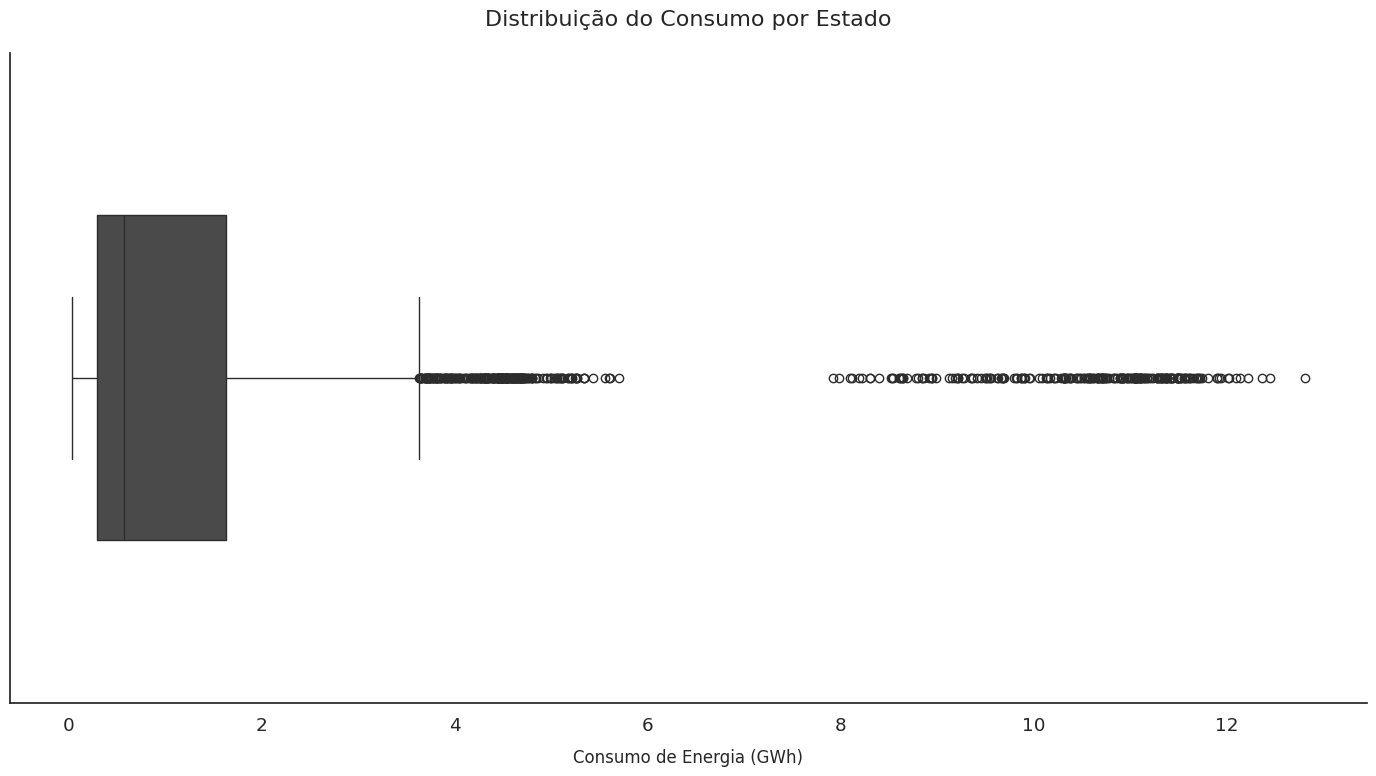

In [316]:
grafico_boxplot(df_total, 'gWh', 'Distribuição do Consumo por Estado', total=True)

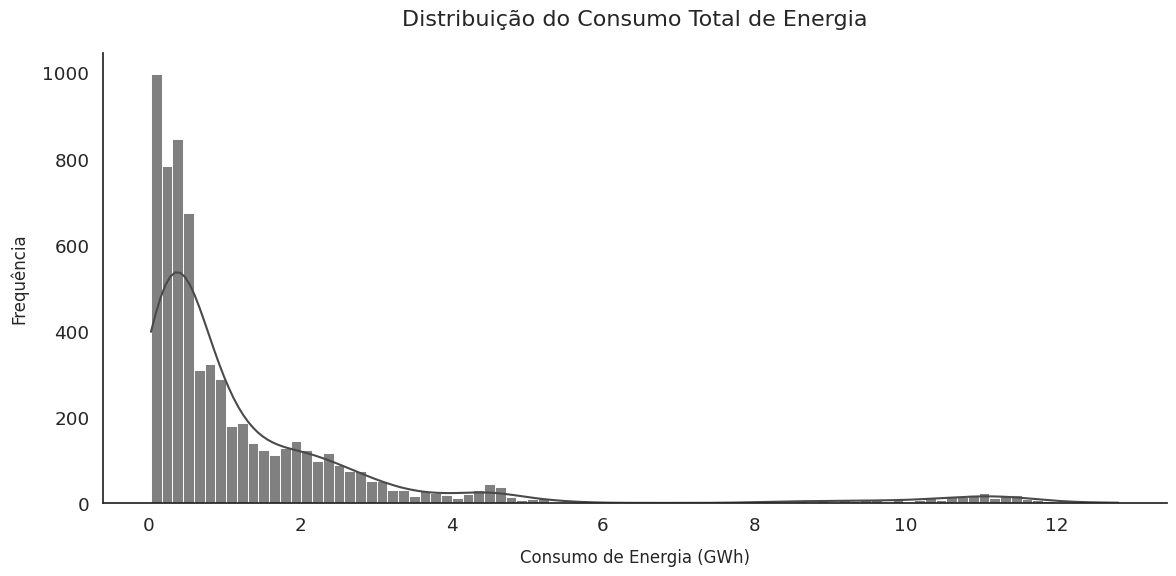

In [317]:
# Definimos o contexto do Seaborn para "notebook" e ajustamos a escala da fonte para garantir que os gráficos sejam legíveis
sns.set_context("notebook", font_scale=1.2)

# Filtramos os dados para obter apenas o consumo total de energia em gigawatts-hora (GWh)
dados_consumo_total = df_total['gWh']

# Criamos a figura e o eixo para o histograma
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Geramos o histograma da distribuição do consumo total de energia, incluindo a curva de densidade (KDE)
sns.histplot(data=dados_consumo_total, kde=True, color='#4a4a4a', alpha=0.7, ax=ax)

# Removemos as bordas superior e direita para um visual mais limpo e moderno
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Configuramos o título e os rótulos dos eixos para expressar com clareza o que o gráfico representa
plt.title('Distribuição do Consumo Total de Energia', fontsize=16, pad=20)
plt.xlabel('Consumo de Energia (GWh)', fontsize=12, labelpad=10)
plt.ylabel('Frequência', fontsize=12, labelpad=10)

# Formatamos o eixo x para incluir separadores de milhares, facilitando a leitura dos valores
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustamos o layout para garantir que todos os elementos do gráfico estejam bem posicionados
plt.tight_layout()

# Salvamos o gráfico em um arquivo e o exibimos na tela para visualização
plt.savefig('../imagens/consumo_total_histograma.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Podemos ver pelo boxplot (primeiro gráfico) que temos a maior parte, primeiro a terceiro quartil, consumindo pouco e temos muito outliers, inclusive com um intervalo criando uma espécie de 2 grupos de outliers. No segundo gráfico, um histograma, podemos ver mais detalhadamente a distribuição que comprova o boxplot, a maior parte concentrada no baixo consumo, uma leve segunda onda próximo aos 4gWh e isoladamente uma terceira onda entre 10 e 12gHw.

Temos três hipoteses:

1. Como estamos vendo todos os anos da série histórica o consumo pode ter mudado muito ao longo do tempo e criou esses outliers pelo aumento ao longo dos anos.
2. Como estamos vendo todos os estados, podemos ter estados com perfis de consumo muito diferentes.
3. Podemos ter dados errados.

## 2. Qual a distribuição dos dados segmentados por ano na base de consumo elétrico da série histórica (2004-2023)

Vamos testar a primeira hipotese, de que o consumo cresceu ou diminuiu ao longo dos anos e isso criou os outliers e para isso vamos plotar um facetgrid, um gráfico facetado por anos.

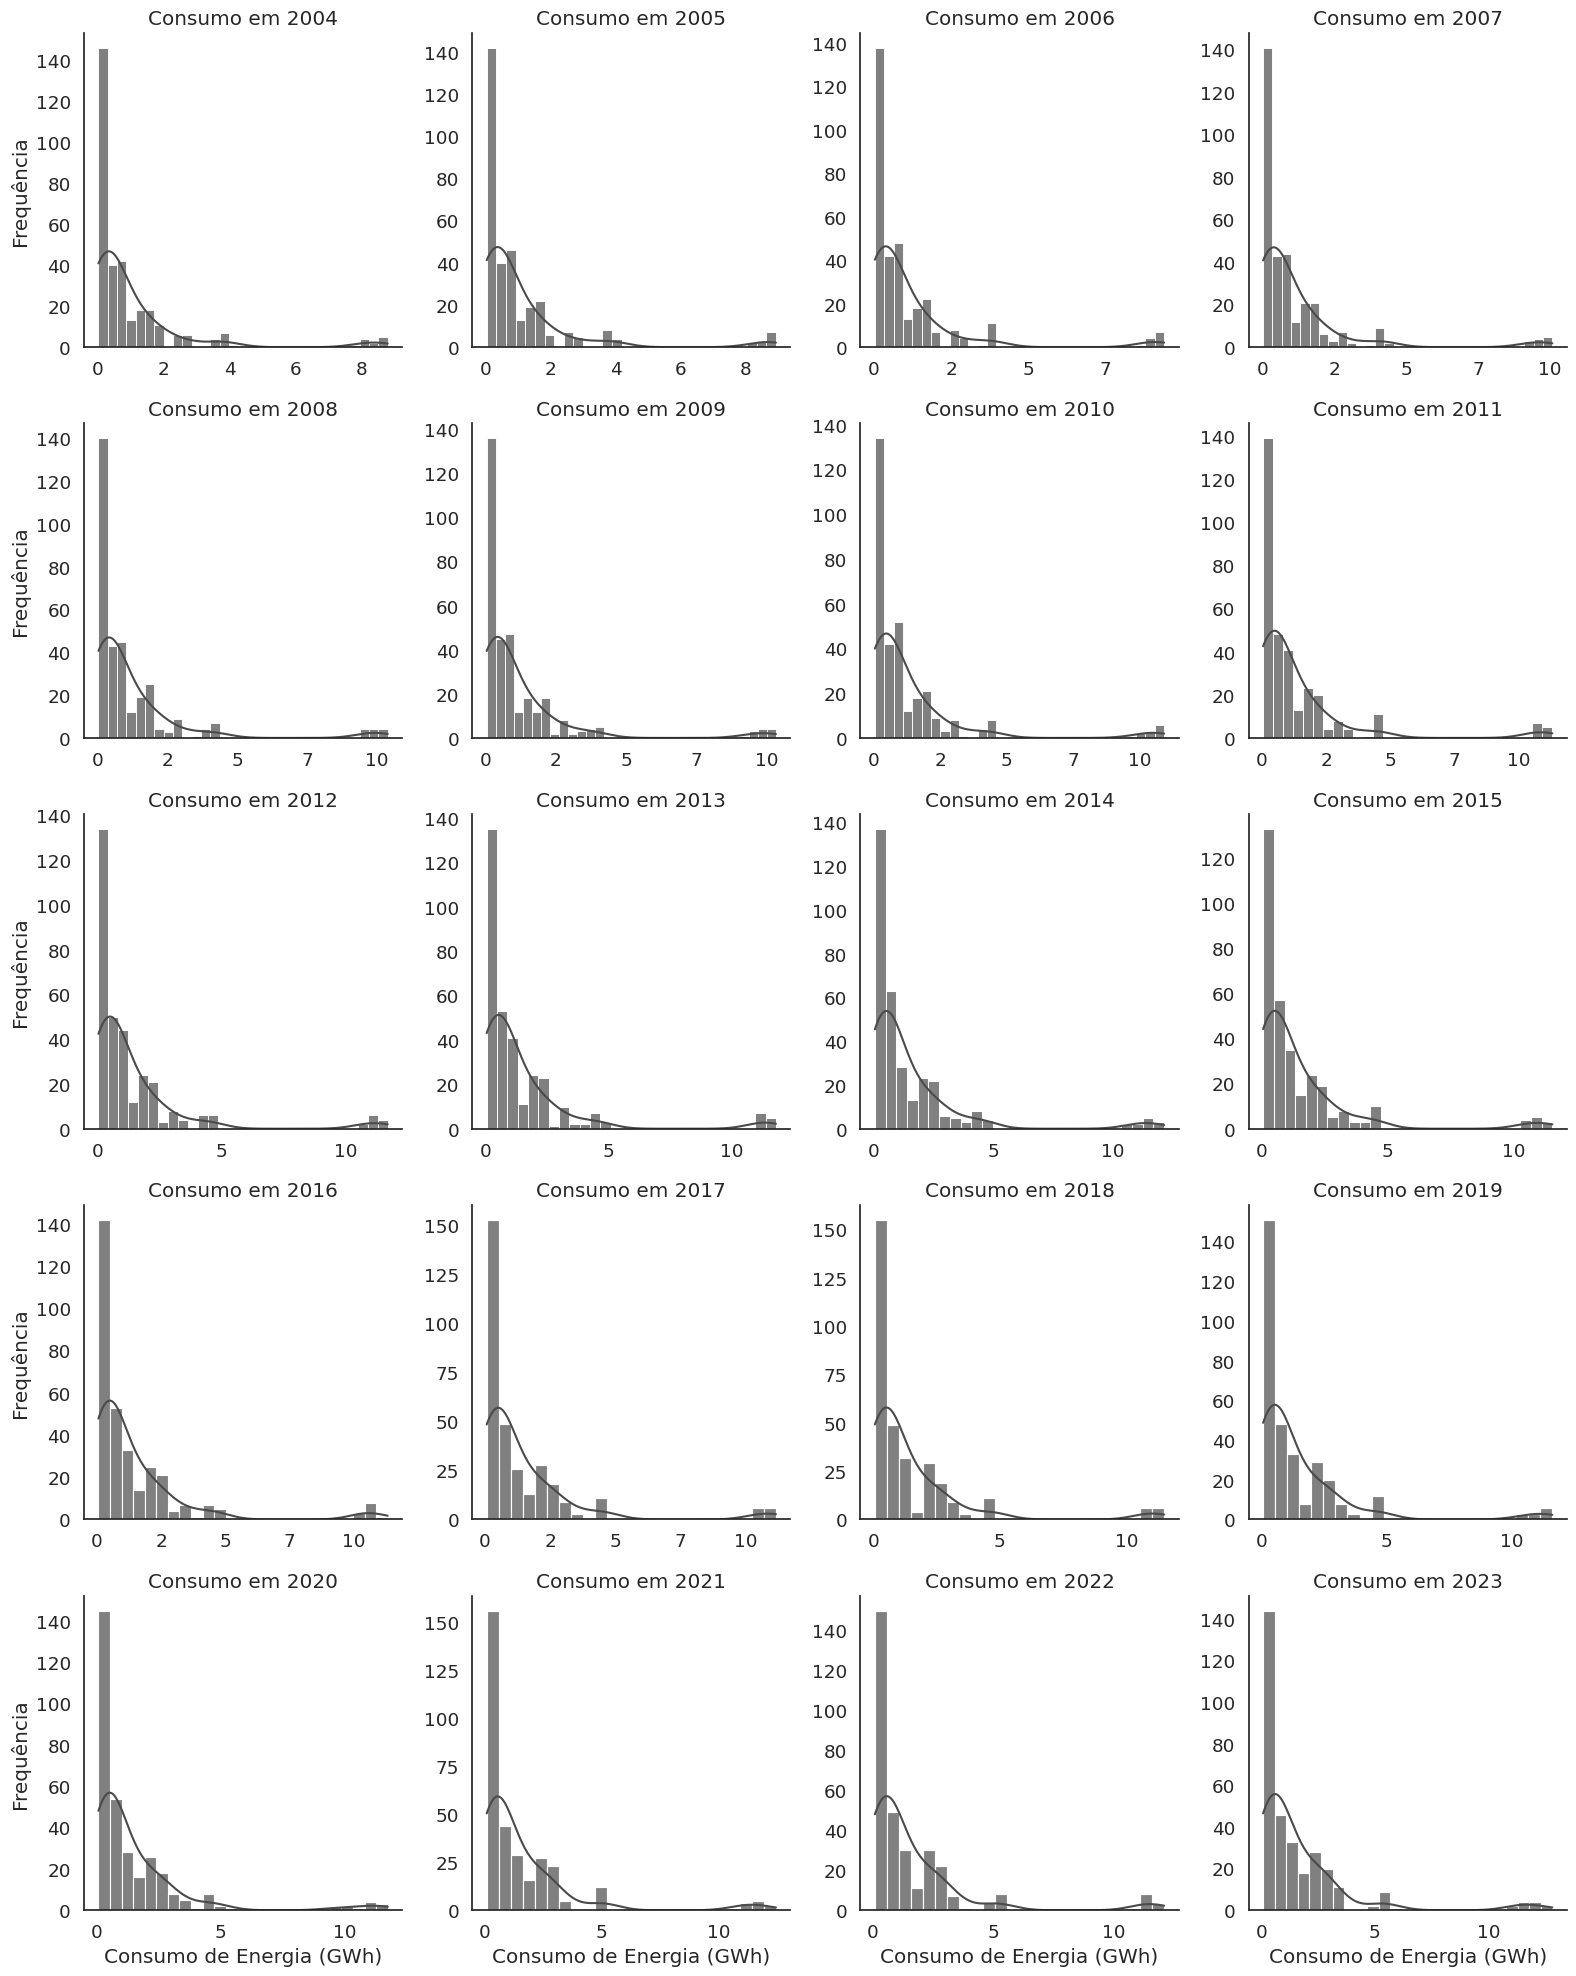

In [318]:
# Configuramos o contexto de exibição dos gráficos com Seaborn para garantir que estejam proporcionais e legíveis
sns.set_context("notebook", font_scale=1.2)

# Criamos um grid de facetas usando o Seaborn para plotar múltiplos histogramas de consumo de energia por ano
g = sns.FacetGrid(df_total, col='ano', col_wrap=4, height=4, sharex=False, sharey=False)

# Mapeamos a função de plotagem dos histogramas para cada faceta, adicionando também a curva de densidade (KDE)
g.map(sns.histplot, 'gWh', kde=True, color='#4a4a4a', alpha=0.7)

# Ajustamos os rótulos dos eixos para cada subplot, garantindo clareza nas informações
g.set_axis_labels('Consumo de Energia (GWh)', 'Frequência')
g.set_titles('Consumo em {col_name}')

# Removemos as bordas superiores e direitas para um visual mais limpo e estético
for ax in g.axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Formatamos o eixo x para incluir separadores de milhares, facilitando a leitura dos dados
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustamos o layout global para assegurar que todos os elementos estejam perfeitamente posicionados
plt.tight_layout()

# Salvamos o grid de gráficos completo em um arquivo para documentação ou apresentação posterior
plt.savefig('../imagens/consumo_total_histograma_facetado.png', format='png', dpi=300, bbox_inches='tight')

# Exibimos o gráfico na tela
plt.show()

Com base em todos os gráficos dessas facetas anuais, não podemos afirmar que o consumo mudou drásticamente. Então vamos passar para a segunda hipotese, de que estados podem ter consumos diferentes. Para isso vamos usar novamente um boxplot, mas agora para cada estado.

## 3. Qual a distribuição dos dados por estado na base de consumo elétrico da série histórica (2004-2023)

Vamos chamar nossa função grafico_boxplot para olhar mais de perto a distribuição das regiões e estados.

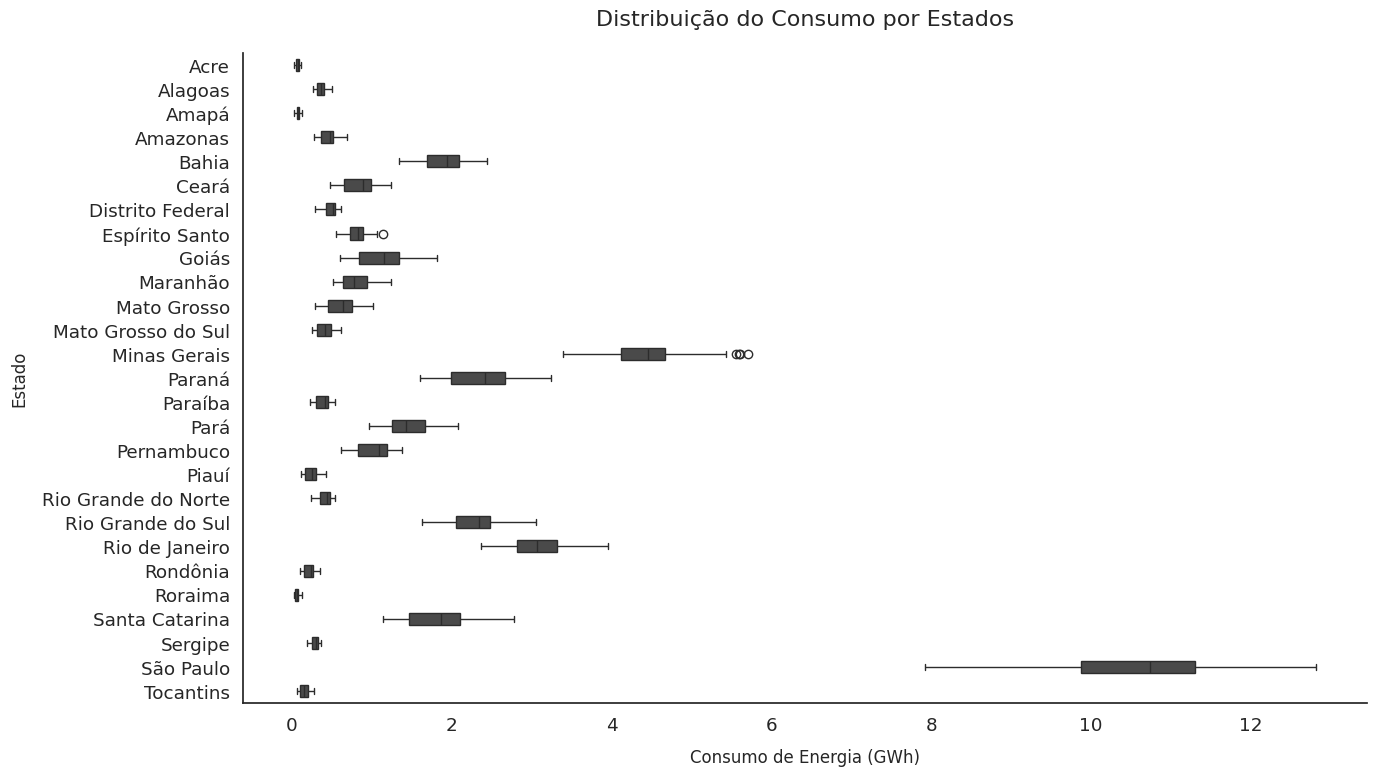

In [319]:
# Chamando a função de forma que tenhamos um boxplot para cada estado
grafico_boxplot(df_total, 'gWh', 'Distribuição do Consumo por Estados')

Agora podemos afirmar com mais clareza e precisão de que os outliers visto no primeiro boxplot se devem ao perfil muito diverso de consumo de estado para estado. Mas em resumo vemos que os dados vão pouco depois do 0gWh e vão até 12gWh, com uma massa concentrada entre 0 e 2, depois uma segunda onda logo após o 4 que se deve a Minas Gerais, que junto com Espirito Santo tem alguns outliers e, por fim, a terceira onda que é São Paulo com primeiro e terceiro quartis entre 10 e 12.

Com isso podemos ter uma ideia bem consolidada da distribuição e comportamento dos dados.

Mas vamos olhar mais de perto por região.

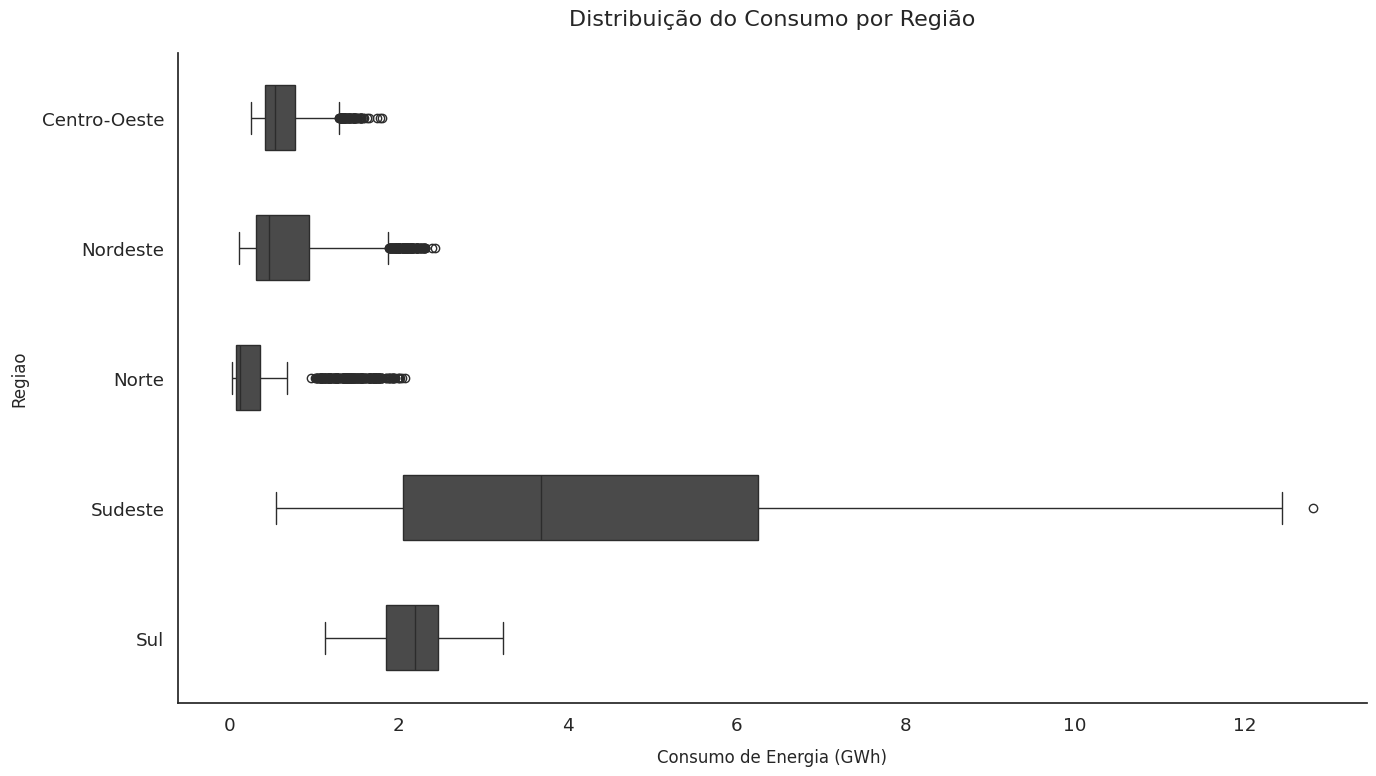

In [320]:
# Aqui criamos uma lista de regiões
regiao = list(df_total['regiao'].unique())

# E usamos essa lista como filtro
grafico_boxplot(df_total, 'gWh', 'Distribuição do Consumo por Região', filtro_regiao=regiao)

Podemos ver mais claramente que a região Sudeste tem a maior distribuição de consumo que vai desde o Espirito Santo que consomo menos até São Paulo que consome muito mais. A região Sul vem em segundo lugar e o mínimo do consumo dessa distribuição é maior que o mínimo da distribuição do Sudeste. Norte tem o menor consumo e isso pode-de se atribuir ao fato de ser uma região com muita zona rural.

Agora vamos criar uma série de variáveis para abarcar cada estado por região.

In [321]:
# criando as listas de estado por região
sul = list(df_total[df_total['regiao'] == 'Sul']['estado'].unique())
sudeste = list(df_total[df_total['regiao'] == 'Sudeste']['estado'].unique())
centro_oeste = list(df_total[df_total['regiao'] == 'Centro-Oeste']['estado'].unique())
norte = list(df_total[df_total['regiao'] == 'Norte']['estado'].unique())
nordeste = list(df_total[df_total['regiao'] == 'Nordeste']['estado'].unique())

E então podemos plotar os gráficos por estados de cada região.

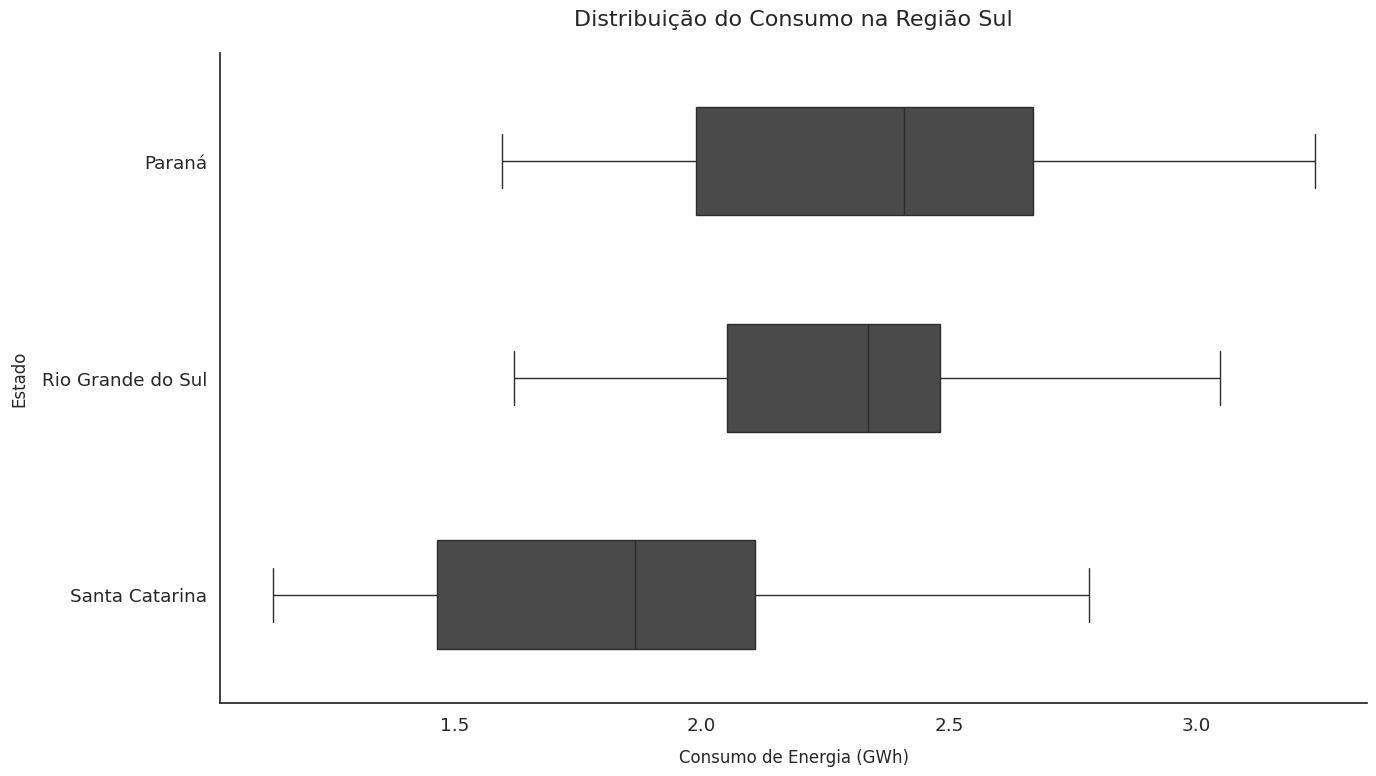

In [322]:
grafico_boxplot(df_total, 'gWh', f'Distribuição do Consumo na Região Sul', filtro_estado=sul)

Paraná consome mais e Santa Catarina menos, Santa Catarina é o menor estado entre os 3.

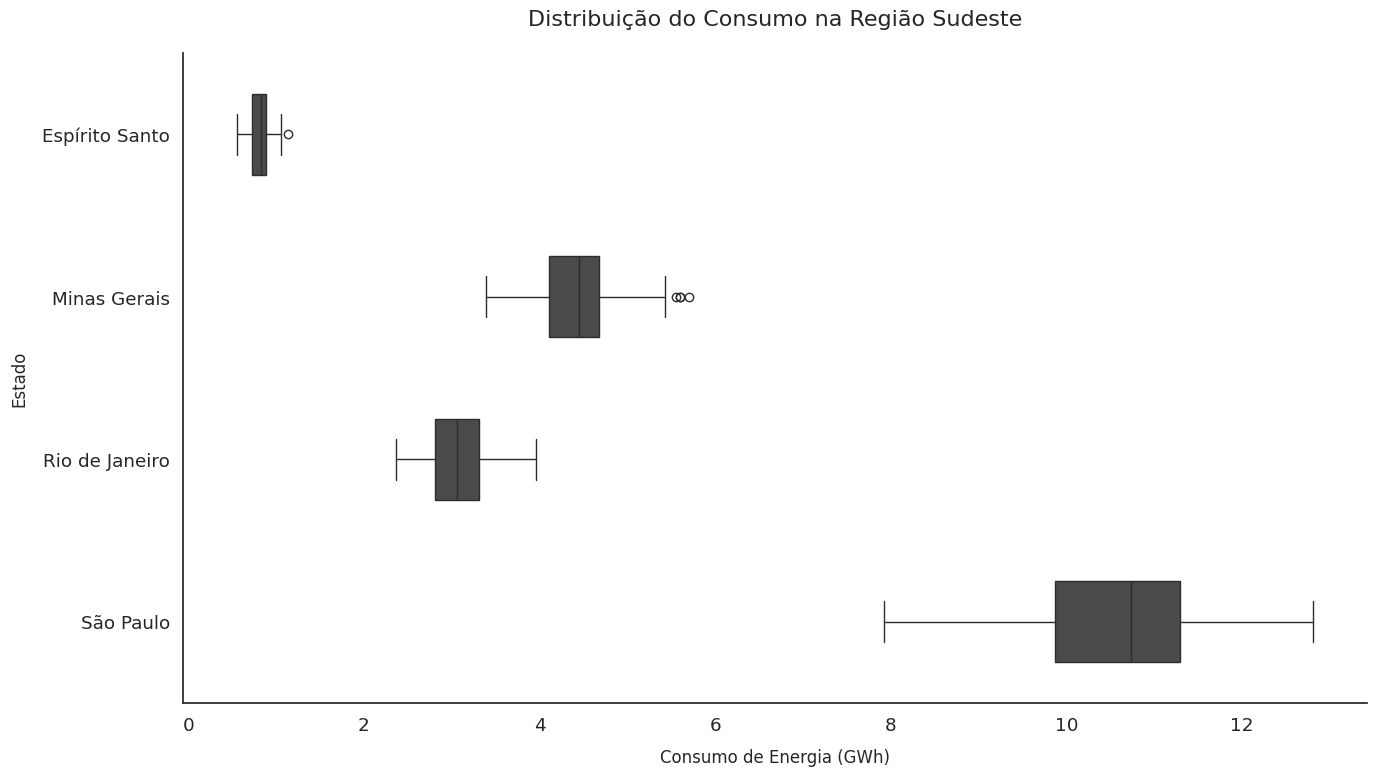

In [323]:
grafico_boxplot(df_total, 'gWh', f'Distribuição do Consumo na Região Sudeste', filtro_estado=sudeste)

São Paulo muito a frente em termos de consumo comparado aos demais estados da região sudeste. Espirito Santo tem um consumo muito similar ao dos estados do Nordeste do qual ele é vizinho. Minas Gerais consome mais do que Rio de Janeiro e possui alguns outliers que pode ter sido algum ano que teve um pico acima da média em consumo

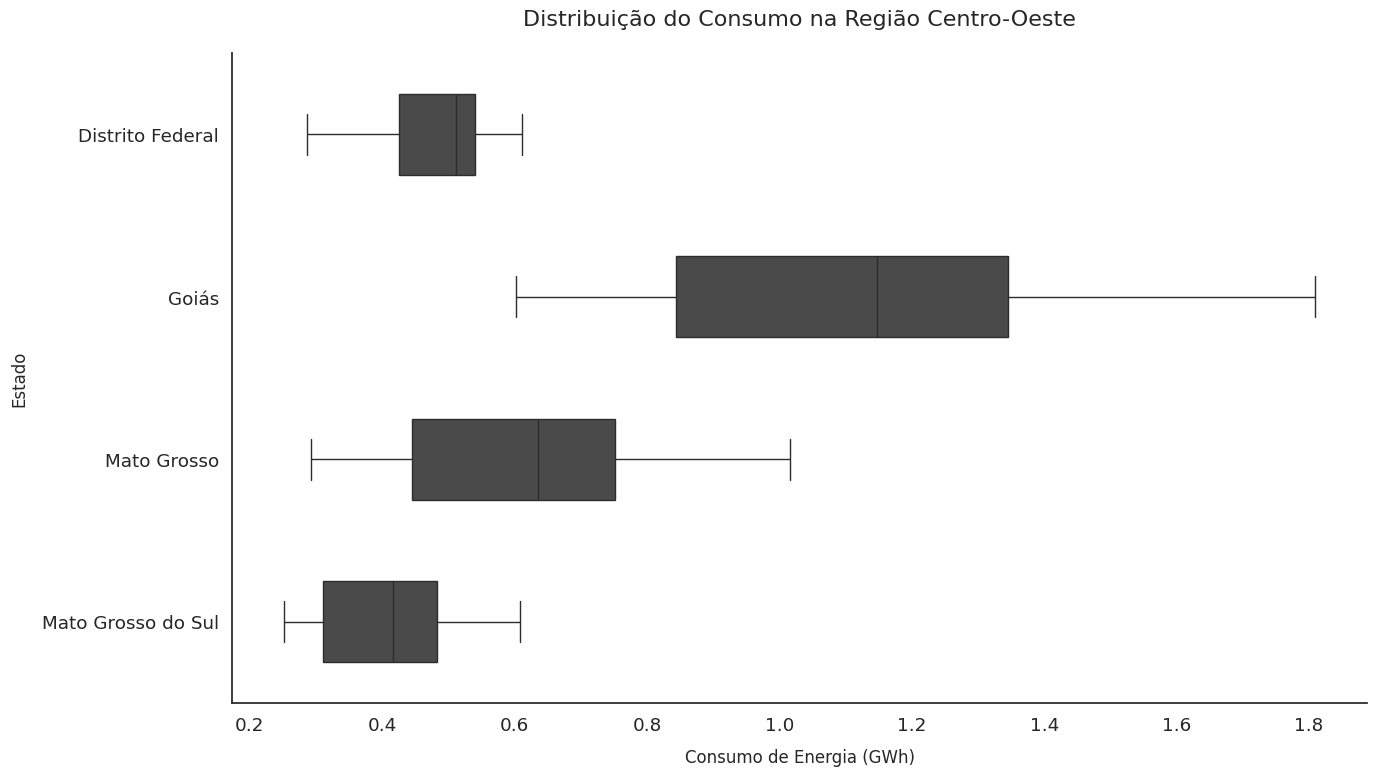

In [324]:
grafico_boxplot(df_total, 'gWh', f'Distribuição do Consumo na Região Centro-Oeste', filtro_estado=centro_oeste)

Goiás consome mais na região

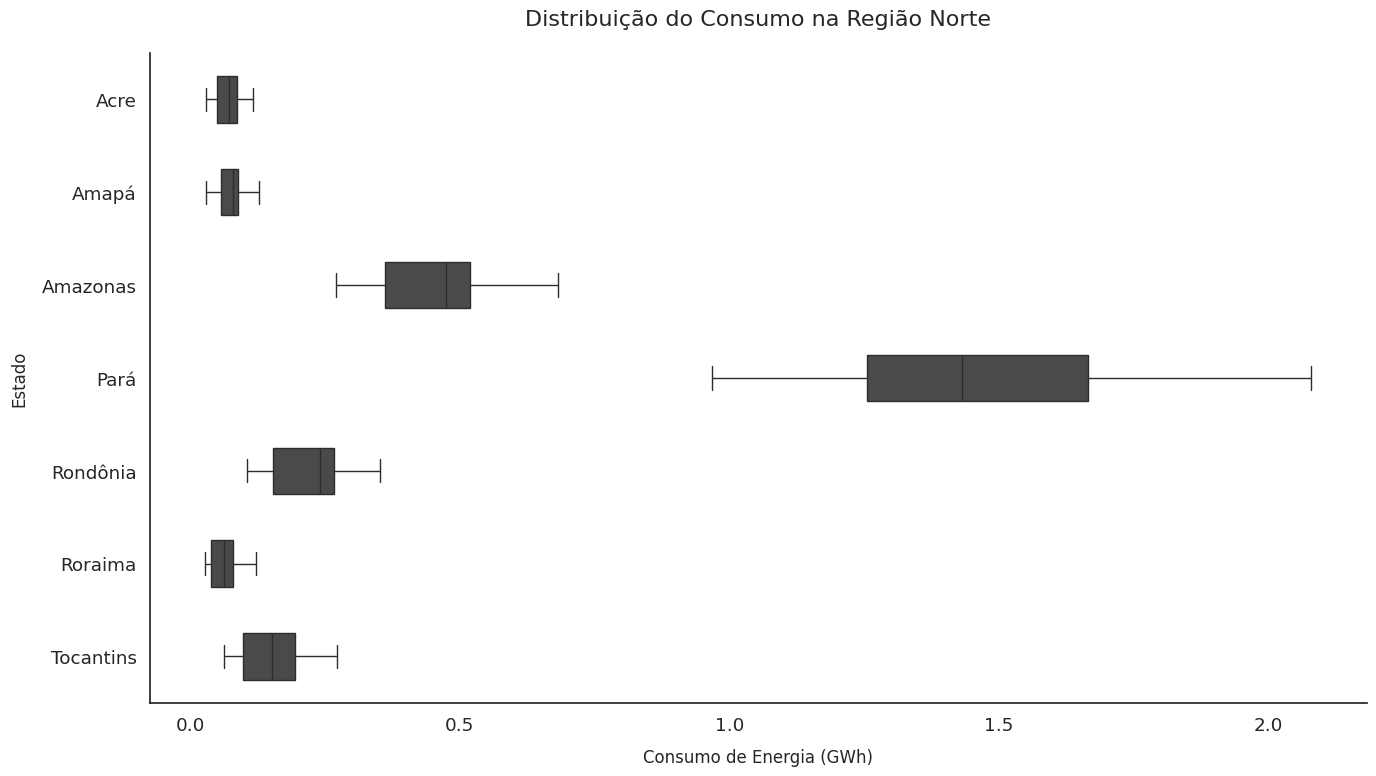

In [325]:
grafico_boxplot(df_total, 'gWh', f'Distribuição do Consumo na Região Norte', filtro_estado=norte)

Pará está bem a frente nessa região e se compara ao Espirito Santo que fica no Sudeste. Vamos comparar.

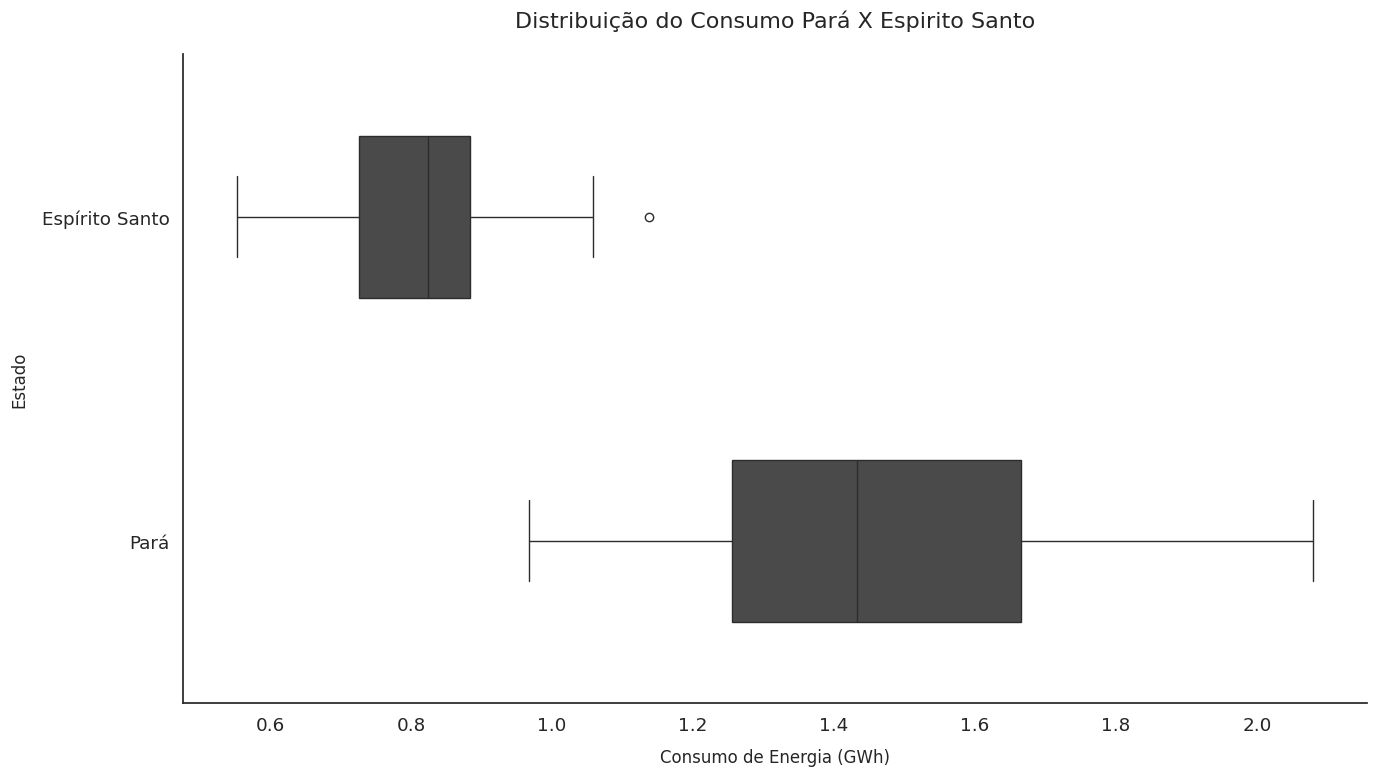

In [326]:
grafico_boxplot(df_total, 'gWh', f'Distribuição do Consumo Pará X Espirito Santo', filtro_estado=['Pará', 'Espírito Santo'])

De fato, não significa que todos os estados de uma região serão um bloco identico no consumo.

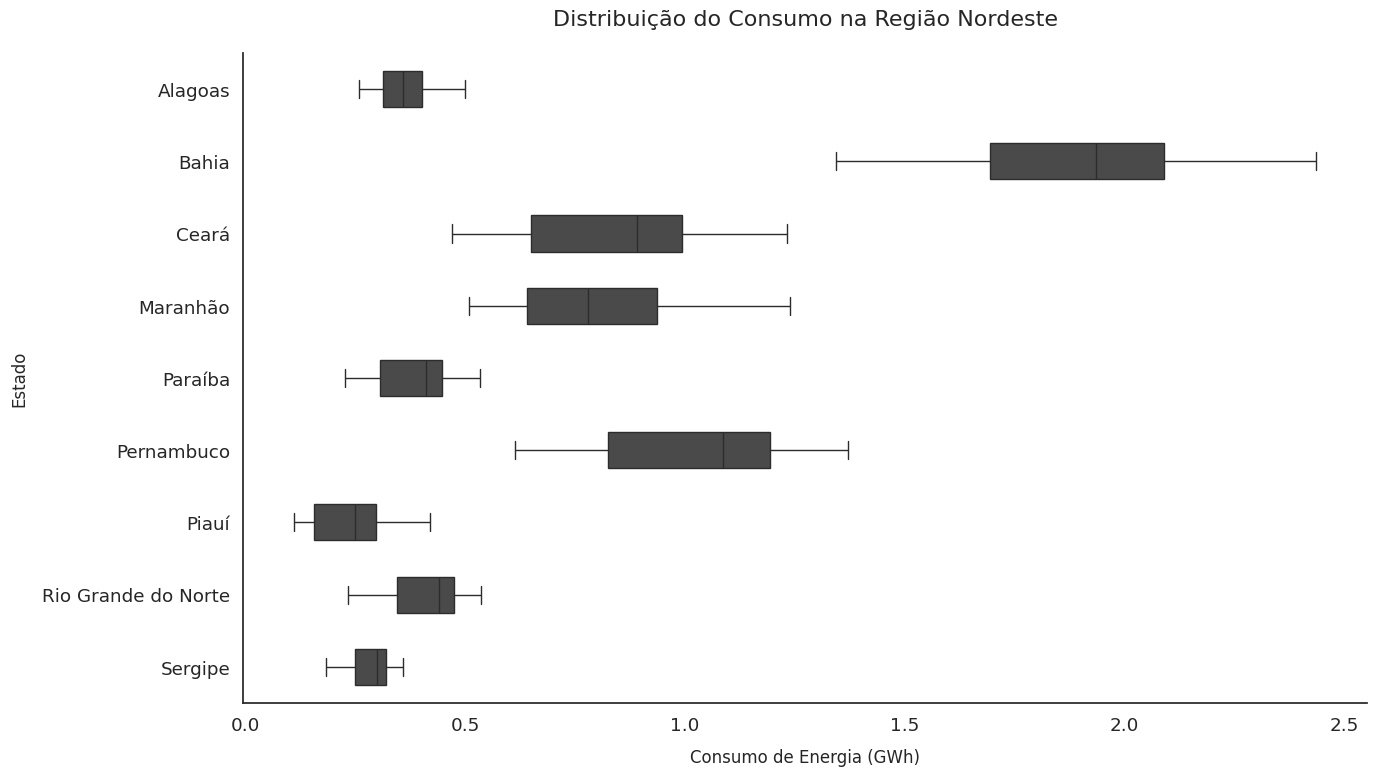

In [327]:
grafico_boxplot(df_total, 'gWh', f'Distribuição do Consumo na Região Nordeste', filtro_estado=nordeste)

O Estado por onde o Brasil nasceu, Bahia, é o que tem o maior consumo no Nordeste.

## 4. Qual foi o consumo máximo geral da série histórica (2004 - 2023)

In [328]:
# Guardando os anos iniciais e finais em variáveis
ano_comeco = df['ano'].min()
ano_fim = df['ano'].max()

# Criando a variável consumo total pelo agrupamento do Total
consumo_total = df.groupby('tipo_consumo')['gWh'].sum().loc['Total']

# Configurando o locale para português do Brasil para facilitar a leitura do número
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

consumo_formatado = locale.format_string('%.2f', consumo_total, grouping=True)

print(f'O Brasil consumiu {consumo_formatado} gWh, contando todos os estados entre {ano_comeco} e {ano_fim}')

O Brasil consumiu 8.791,31 gWh, contando todos os estados entre 2004 e 2023


## 5. Qual a evolução do consumo máximo geral anual da série histórica (2004 - 2023)

Vamos olhar o consumo total, somando todos os anos de todos os estados e ver se ele cresceu ou diminuiu.

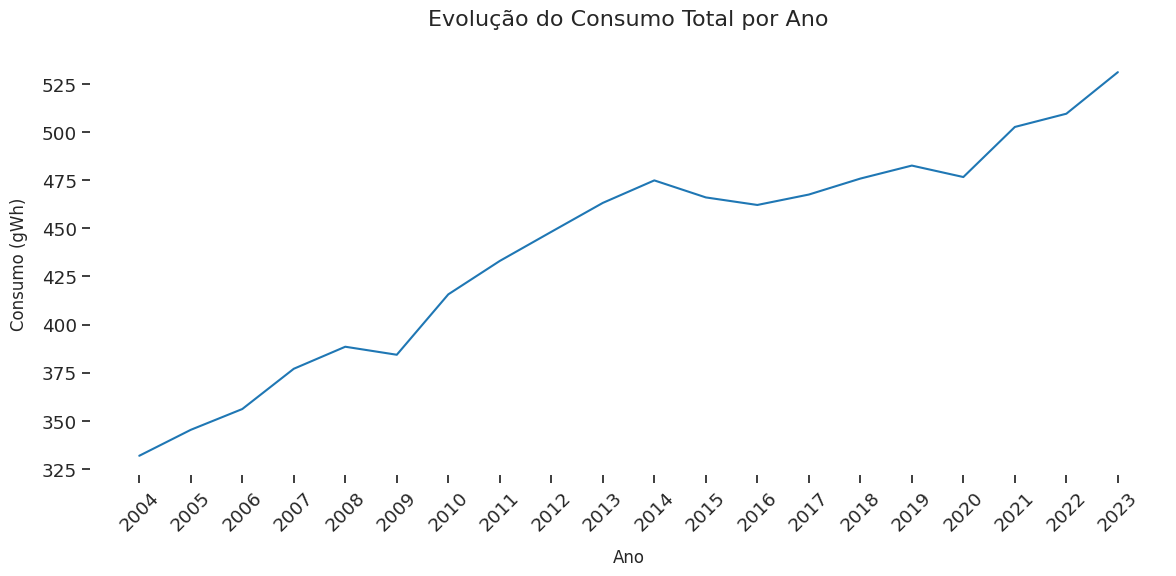

In [329]:
# Usando a função para plotar gráfico de linha
grafico_linha(df, coluna_y='gWh', 
              titulo='Evolução do Consumo Total por Ano', 
              rotulo_y='Consumo (gWh)')

Podemos observar que o consumo cresceu ao longo dos anos.

Alguns fatos que ocorreram nesses anos:

2004-2008: Crescimento Econômico e Expansão Industrial

2009: Crise Financeira Global

Maior apagão do Brasil em 2009: https://memoriaglobo.globo.com/jornalismo/jornalismo-e-telejornais/jornal-nacional/reportagens-e-entrevistas/noticia/apagao-no-brasil-em-2009.ghtml

2010-2014: Recuperação e Grandes Eventos como Copa do mundo.

2015-2016: Crise Econômica e Política e Olimpíadas em 2016

2017-2019: Recuperação Econômica Lenta

2020: Pandemia de COVID-19

2021-2023: Retomada e Sustentabilidade

## 6. Qual a evolução da base consumidora na série histórica (2004 - 2023)?

Vamos agrupar o número total de consumidores por estado ao longo da série histórica e depois plotar um gráfico de linha para mostrar essa evolução, assumimos que total é justamente a soma dos tipos de consumo e que cativo faz parte do total, mas não é uma categoria contabilizada

In [330]:
ano_inicial = 2004
ano_final = 2023

In [331]:
consumidores_anuais = pd.DataFrame(df[df['mes'] == 12].groupby('ano')['numero_consumidores'].sum()).reset_index()
consumidores_anuais['tipo_consumo'] = 'Total'

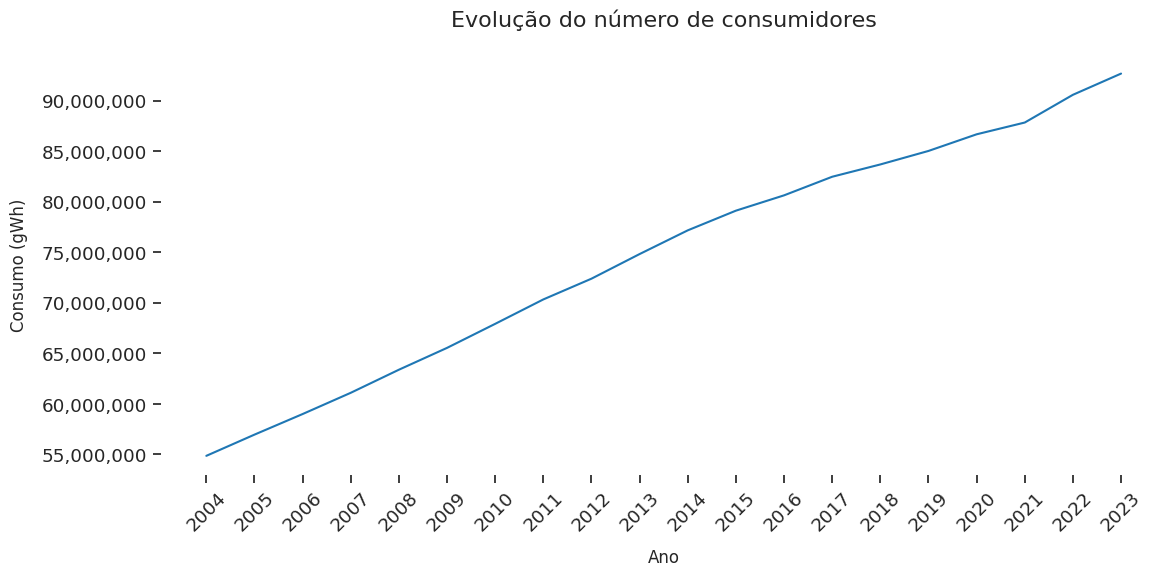

In [332]:
# Usando a função para plotar gráfico de linha
grafico_linha(consumidores_anuais, coluna_y='numero_consumidores',
              eixo_x='ano', 
              titulo='Evolução do número de consumidores', 
              rotulo_y='Consumo (gWh)',
              funcao_agg='media',
              milhares=True)

## 7. Como é o crescimento da base consumidora e da população geral?

In [333]:
# Dados do censo
anos_censo = [2000, 2010, 2022]
pop_censo = [pop_2000_brasil, pop_2010_brasil, pop_2022_brasil]

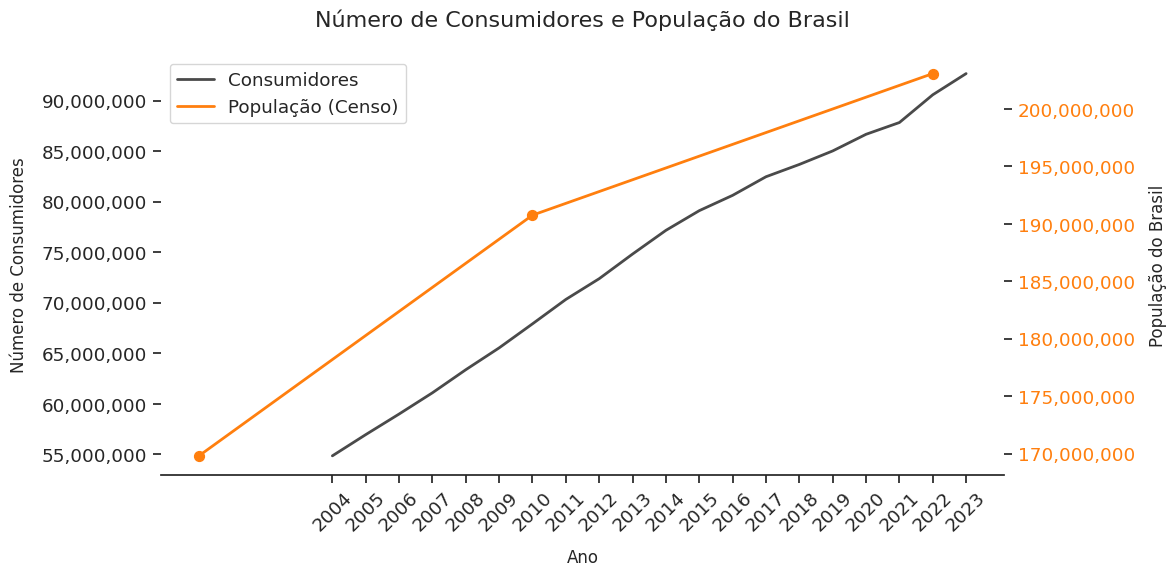

In [335]:
# Criamos a figura e o eixo principal para o gráfico de linha
fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotamos o gráfico de linha para o número de consumidores ao longo dos anos
sns.lineplot(x=consumidores_anuais['ano'], y=consumidores_anuais['numero_consumidores'], 
             color='#4a4a4a', linewidth=2, ax=ax1, label='Consumidores')

# Removemos as bordas para um visual mais limpo
for spine in ax1.spines.values():
    spine.set_visible(False)

# Configuramos os ticks dos eixos, mantendo apenas os inferiores no eixo x e os esquerdos no eixo y
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax1.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustamos o intervalo do eixo x para que todos os anos relevantes sejam exibidos
plt.xticks(range(ano_inicial, ano_final + 1))

# Rotacionamos os rótulos do eixo x em 45 graus para melhorar a legibilidade
plt.xticks(rotation=45)

# Configuramos o título e os rótulos dos eixos para esclarecer o que o gráfico representa
plt.title('Número de Consumidores e População do Brasil', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
ax1.set_ylabel('Número de Consumidores', fontsize=12, labelpad=10)

# Formatamos o eixo y do número de consumidores para incluir separadores de milhares
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Criamos um segundo eixo y para representar a população
ax2 = ax1.twinx()

# Plotamos a linha da população ao longo dos anos de censo, incluindo pontos de dados para clareza
ax2.plot(anos_censo, pop_censo, color='#ff7f0e', linewidth=2, label='População (Censo)')
ax2.scatter(anos_censo, pop_censo, color='#ff7f0e', s=50)

# Configuramos o eixo y para a população, com rótulos coloridos para diferenciar visualmente
ax2.set_ylabel('População do Brasil', fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Removemos bordas do eixo secundário, exceto a esquerda para manter integridade visual
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Adicionamos legendas para distinguir entre as linhas de consumidores e população
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Ajustamos o layout para assegurar clareza e legibilidade
plt.tight_layout()

# Salvamos o gráfico em um arquivo e o exibimos na tela para visualização
plt.savefig('../imagens/numero_consumidores_e_populacao.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Esse gráfico trabalha com duas escalas e tem o intuito de comparar o crescimento da população geral e o de consumidores e podemos ver que a reta dos consumidores tem uma evolução mais vigorosa enquanto a população geral mostra uma desaceleração. É importante notar que para cada consumidor pode haver uma família de pessoas.

## 8. O quanto do consumo acumulado entre 2004 e 2023 é cativo em relação ao total?

Vamos voltar a esse assunto e entender como se comporta esse regime de contratos. Vamos agrupar por tipo de consumo a soma deles e dividir Cativo por Total.

In [336]:
# vamos agrupar por tipo de consumo e pegar o valor em Cativo
consumo_total_cativo = df.groupby('tipo_consumo')['gWh'].sum().loc['Cativo']

# obtendo a porcentagem do consumo cativo dividindo pelo consumo total
consumo_total_cativo_relativo = consumo_total_cativo / consumo_total * 100

print(f'O consumo cativo acumulado em comparação ao consumo acumulado total é {consumo_total_cativo_relativo:.2f}%')

O consumo cativo acumulado em comparação ao consumo acumulado total é 70.54%


## 9. Evolução do consumo cativo ao longo da série histórica (2004 - 2023)

Vamos agora obter o valor do consumo cativo a cada ano. Criando uma variável para agrupar anualmente os consumos cativo e total e também descobrir o consumo livre que é a diferença entre total e cativo.

In [390]:
# Criando a variável que agrupa consumo total por ano em gWh
consumo_anual_total = df[df['tipo_consumo'] == 'Total'].groupby('ano')['gWh'].sum()

# Criando a variável que agrupa consumo cativo por ano em gWh
consumo_anual_cativo = df[df['tipo_consumo'] == 'Cativo'].groupby('ano')['gWh'].sum()

In [391]:
# Criamos um DataFrame combinando as duas séries
df_consumo = pd.DataFrame({
    'Cativo': consumo_anual_cativo,
    'Total': consumo_anual_total
})

In [392]:
# Calculando o consumo livre (diferença entre total e cativo)
df_consumo['Livre'] = df_consumo['Total'] - df_consumo['Cativo']

In [393]:
df_consumo

,Cativo,Total,Livre
ano,,,
2004,283.032843,331.865053,48.832210
2005,265.063058,345.336121,80.273063
2006,262.616118,356.129174,93.513056
2007,273.441465,377.030014,103.588549
2008,289.210060,388.472393,99.262333
2009,295.294514,384.306370,89.011856
2010,310.352875,415.667749,105.314874
2011,320.351763,433.015628,112.663865
2012,327.498503,448.126379,120.627876


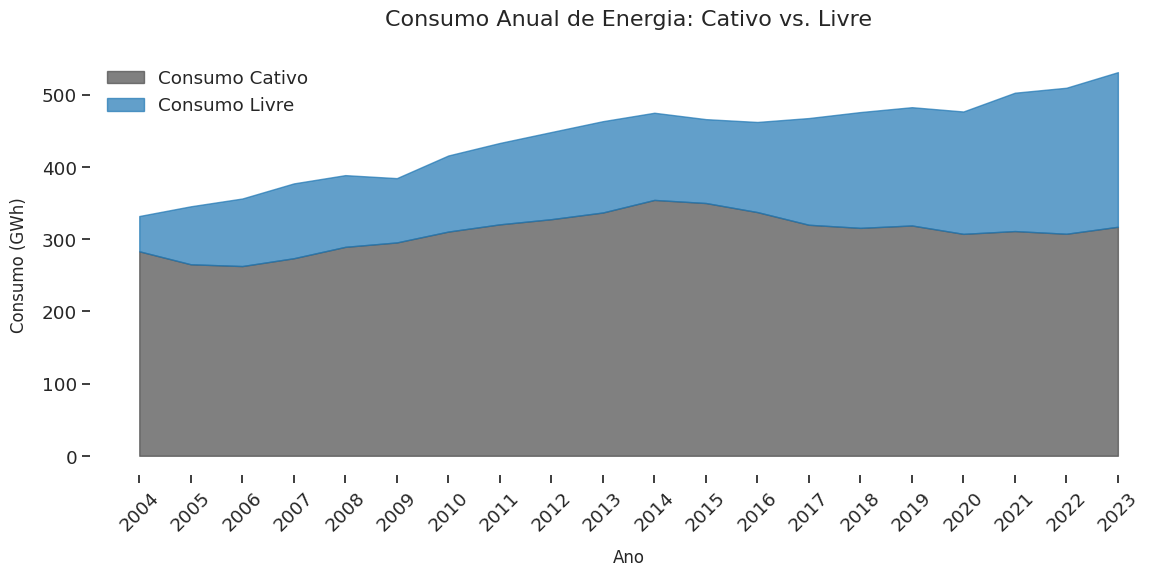

In [342]:
# Criamos a figura e o eixo para o gráfico de área
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotamos o gráfico de área para o consumo de energia, diferenciando entre consumo cativo e livre
ax.fill_between(df_consumo.index, 0, df_consumo['Cativo'], alpha=0.7, color='#4a4a4a', label='Consumo Cativo')
ax.fill_between(df_consumo.index, df_consumo['Cativo'], df_consumo['Total'], alpha=0.7, color='#1f77b4', label='Consumo Livre')

# Removemos as bordas para um visual mais limpo usando uma função personalizada
for spine in ax.spines.values():
    spine.set_visible(False)

# Configuramos os ticks do eixo x usando uma função personalizada
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustamos o intervalo do eixo x para cobrir todos os anos de 2004 a 2023
plt.xticks(range(2004, 2024))

# Rotacionamos os rótulos do eixo x em 45 graus para melhorar a legibilidade
plt.xticks(rotation=45)

# Configuramos o título e os rótulos dos eixos para esclarecer o que o gráfico representa
plt.title('Consumo Anual de Energia: Cativo vs. Livre', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel('Consumo (GWh)', fontsize=12, labelpad=10)

# Adicionamos uma legenda para identificar as áreas do gráfico
plt.legend(loc='upper left', frameon=False)

# Ajustamos o layout para garantir que todos os elementos estejam bem posicionados e não se sobreponham
plt.tight_layout()

# Salvamos o gráfico em um arquivo e o exibimos na tela para visualização
plt.savefig('../imagens/consumo_anual_cativo_livre.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Podemos notar que o consumo livre foi aumentando ao longo do tempo. 

## 10. Qual a evolução percentual do consumo livre de energia ao longo da série histórica?

Lembrando que o consumo livre é a diferença entre Total e Cativo.

In [ ]:
# Ajustando o df_consumo retirando o índice
df_consumo = df_consumo.reset_index()

In [ ]:
# Criando a coluna para armazenar o valor percentual
df_consumo['livre_relativo'] = df_consumo['Livre'] / df_consumo['Total'] * 100

In [346]:
df_consumo

,ano,Cativo,Total,Livre,livre_relativo
0,2004,283.032843,331.865053,48.832210,14.714478
1,2005,265.063058,345.336121,80.273063,23.244908
2,2006,262.616118,356.129174,93.513056,26.258185
3,2007,273.441465,377.030014,103.588549,27.474881
4,2008,289.210060,388.472393,99.262333,25.551966
5,2009,295.294514,384.306370,89.011856,23.161692
6,2010,310.352875,415.667749,105.314874,25.336311
7,2011,320.351763,433.015628,112.663865,26.018429
8,2012,327.498503,448.126379,120.627876,26.918272
9,2013,336.739721,463.142489,126.402768,27.292415


In [ ]:
# Mesclando com df_total para pegar outros dados necessários para o gráfico
df_consumo = df_total.merge(df_consumo, on='ano')

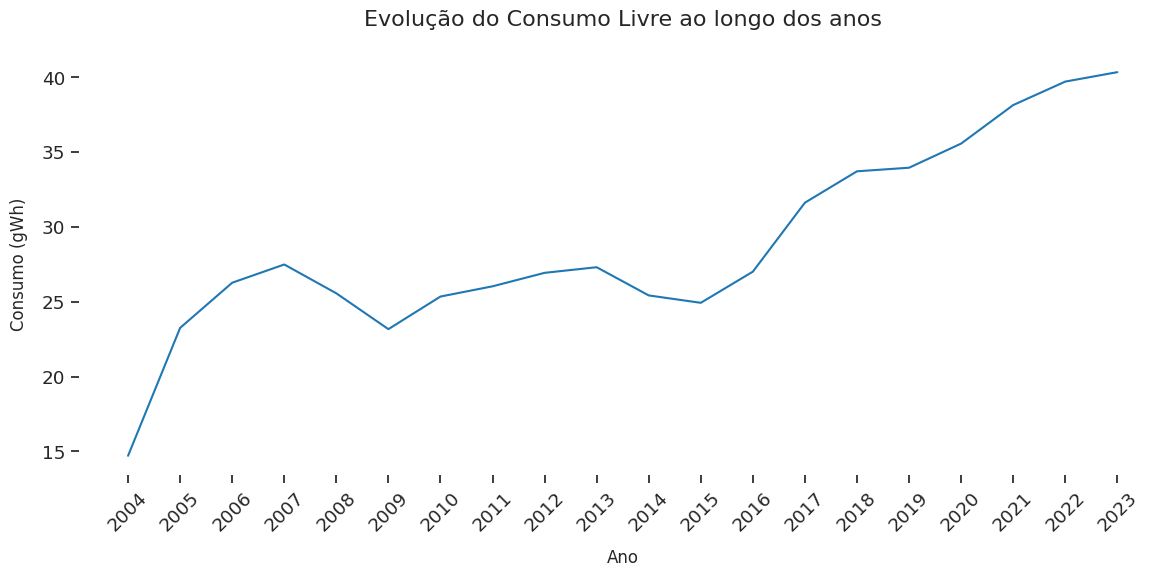

In [ ]:
# Plotando o gráfico
grafico_linha(df_consumo, eixo_x='ano', coluna_y='livre_relativo', 
              titulo='Evolução do Consumo Livre ao longo dos anos', 
              rotulo_y='Consumo (gWh)', funcao_agg='media')

## 11. Há sazonalidade no consumo da série histórica (2004 - 2023)

Vamos plotar um gráfico filtrado por região para vermos se há alguma sazonalidade mensal no consumo elétrico, principalmente entre meses frios, como junho, julho e agosto aos demais.

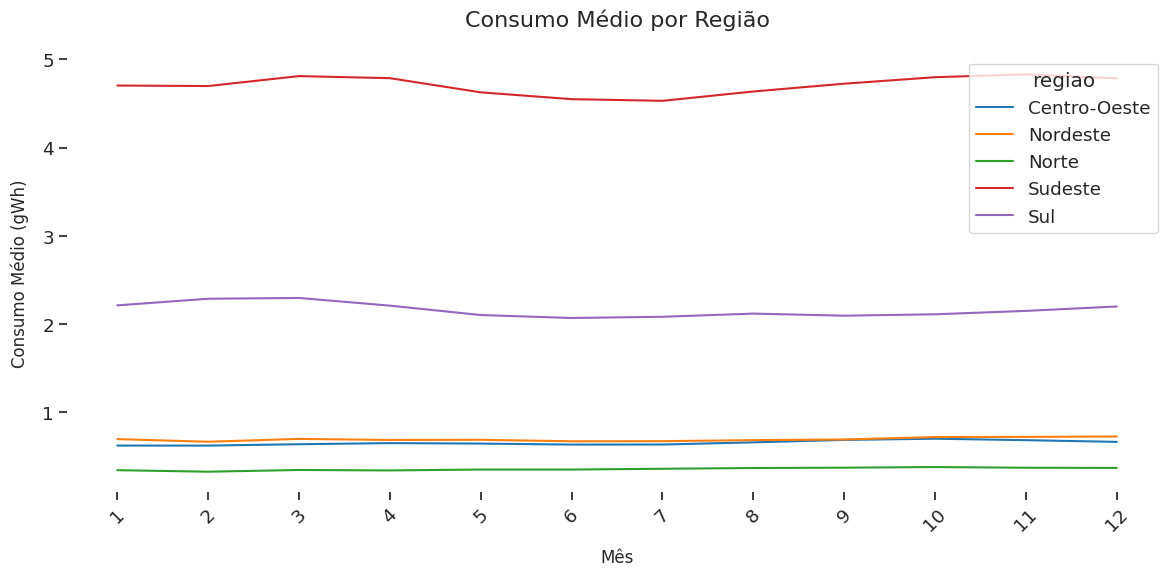

In [446]:
grafico_linha(df, coluna_y='gWh', 
              titulo='Consumo Médio por Região',
              eixo_x='mes', 
              rotulo_y='Consumo Médio (gWh)',
              filtro_regiao=regiao,
              hue='regiao',
              funcao_agg='media')

Há uma leve variação em algumas regiões para os meses mais frios, mas como está é difícil perceber.

## 12. Há uma sazonalidade mais acentuada nos estados do sul em relação aos do Norte e Nordeste?

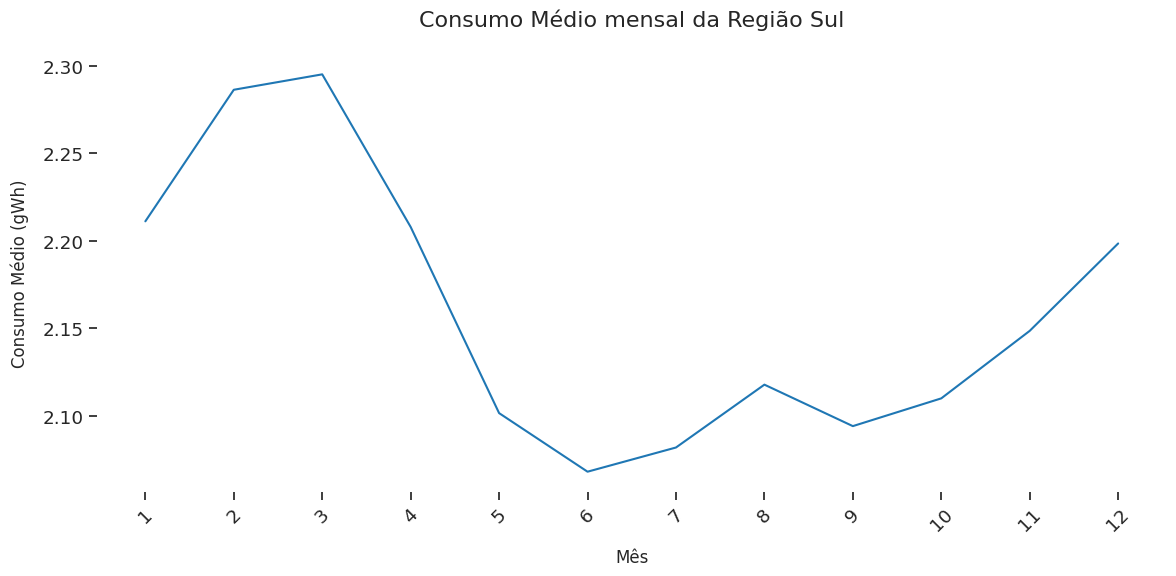

In [442]:
grafico_linha(df, coluna_y='gWh', 
              titulo='Consumo Médio mensal da Região Sul',
              eixo_x='mes', 
              rotulo_y='Consumo Médio (gWh)',
              filtro_regiao=['Sul'],
              funcao_agg='media')

Podemos ver que a região sul tem um consumo menor nos meses mais frios, pois tem temperaturas muito menores do que o resto do país. 

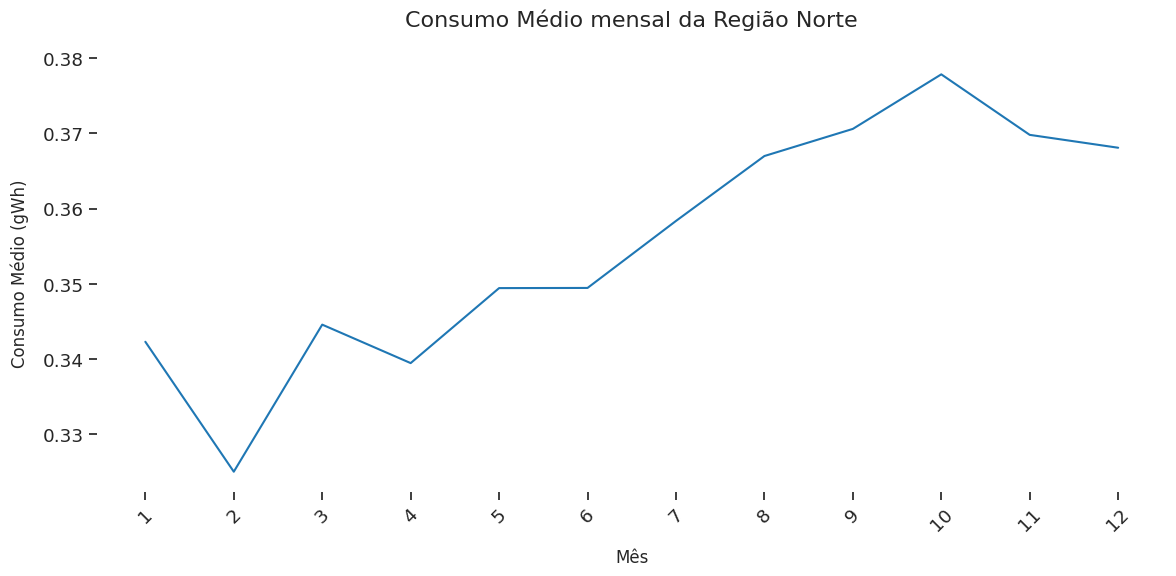

In [443]:
grafico_linha(df, coluna_y='gWh', 
              titulo='Consumo Médio mensal da Região Norte',
              eixo_x='mes', 
              rotulo_y='Consumo Médio (gWh)',
              filtro_regiao=['Norte'],
              funcao_agg='media')

Já o comportamente da região Norte apresenta um aumento ao longo dos meses, com pico em novembro, ou seja, comparada à região Sul, não há menos consumo nos meses de inverno

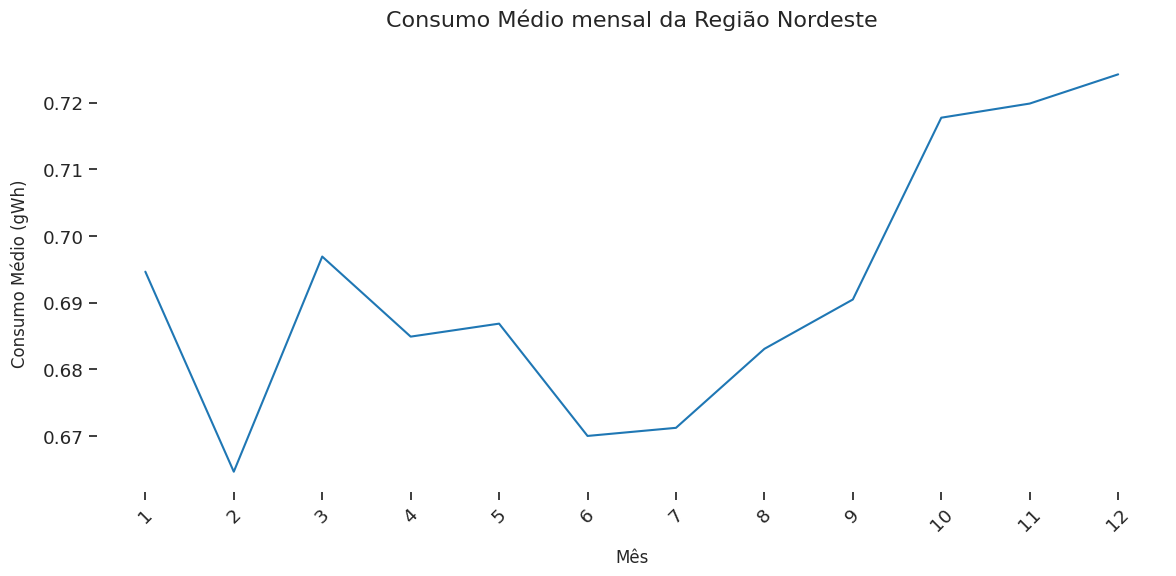

In [444]:
grafico_linha(df, coluna_y='gWh', 
              titulo='Consumo Médio mensal da Região Nordeste',
              eixo_x='mes', 
              rotulo_y='Consumo Médio (gWh)',
              filtro_regiao=['Nordeste'],
              funcao_agg='media')

Já a região Nordeste chega a apresentar uma queda no inverno e estranhamente tem o mês de fevereiro com baixo consumo.

## 13. Tipos de consumo anual da série histórica (2004 - 2023)

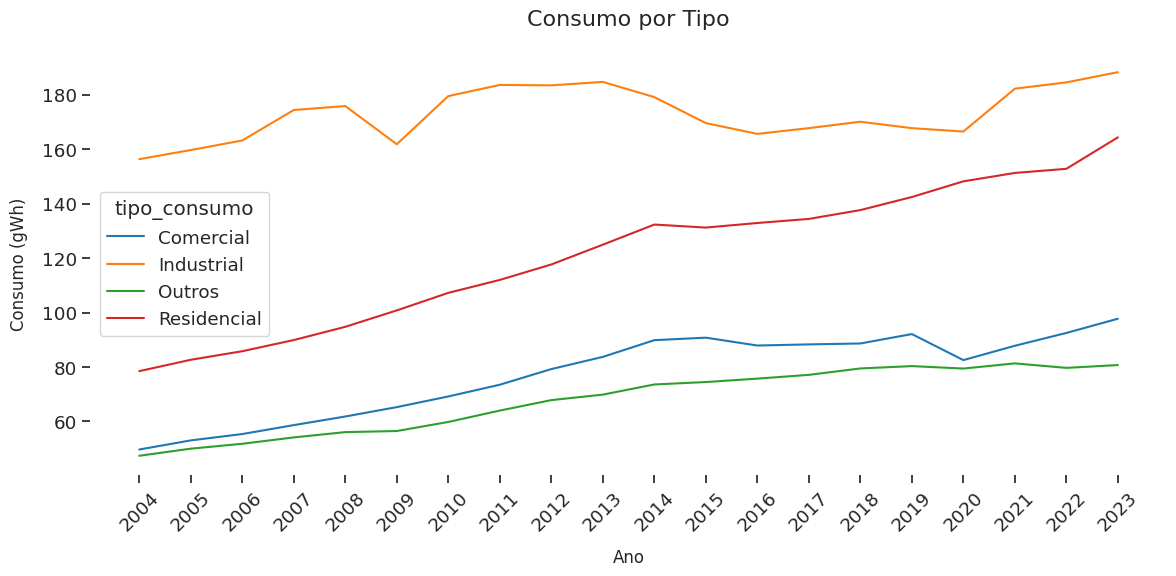

In [356]:
# Gráfico detalhado por tipo de consumo
grafico_linha(df, coluna_y='gWh', 
              titulo='Consumo por Tipo', 
              rotulo_y='Consumo (gWh)',
              tipo_consumo='detalhado')

## 14. Qual o consumo por região na série histórica (2004-2023)?

Vamos segmentar o consumo por região e descobrir o comportamento de consumo

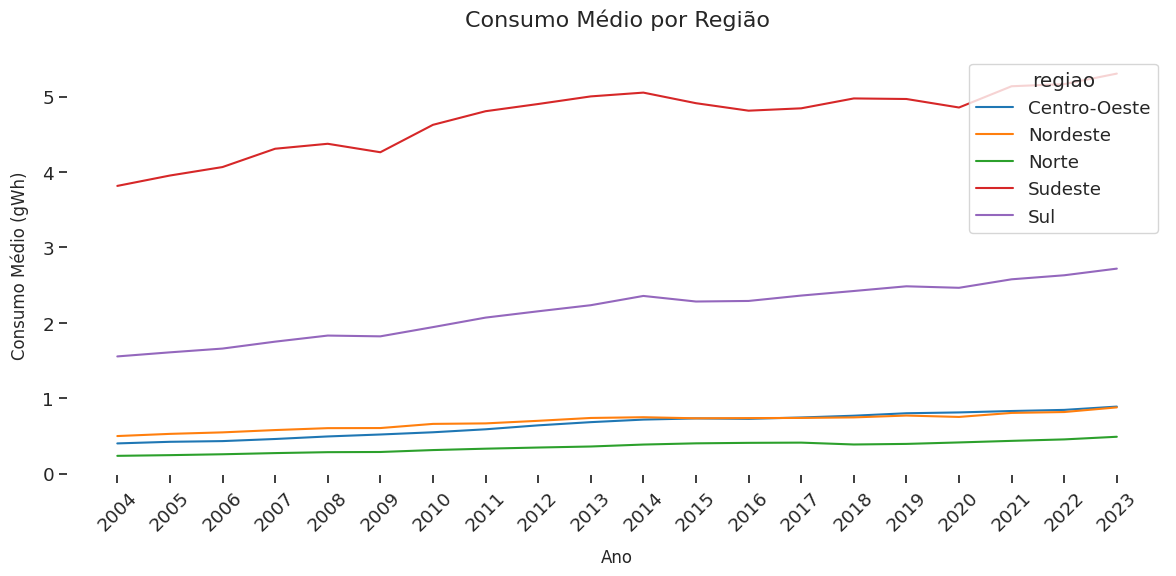

In [357]:
# Gráfico por região usando média
grafico_linha(df, coluna_y='gWh', 
              titulo='Consumo Médio por Região', 
              rotulo_y='Consumo Médio (gWh)',
              filtro_regiao=['Sul', 'Sudeste', 'Centro-Oeste', 'Norte', 'Nordeste'],
              funcao_agg='media',
              hue='regiao')

Podemos obsersvar que a região sudeste sempre esteve muito a frente das demais regiões em toda a série histórica, também que Nordeste e Sul tem um consumo parecido, da mesma forma que as regiões Centro-Oeste e Norte. Todas crescerem ao longo do tempo.

## 15. Há alguma possível correlação entre o IDH e o consumo de energia?

Agora vamos fazer uma correlação entre IDHM e consumo em gWh para saber se existe alguma correlação.

In [358]:
# Calculamos a correlação entre o IDHM e o consumo médio anual de energia (gWh)
# no DataFrame idhm_consumo_estados. Isso ajuda a identificar a relação linear
# entre essas duas variáveis.
correlacao = idhm_consumo_estados[['idhm', 'gWh']].corr()

# Exibimos a matriz de correlação
print(correlacao)

          idhm       gWh
idhm  1.000000  0.511172
gWh   0.511172  1.000000


Podemos extrair uma correlação positiva moderada de 0,51 o que implica dizer que a medida que o IDHM aumenta o consumo tende a acompanhar. Mas correlação não significa necessariamente causalidade, outros fatores como uma forte industrialização e infraestrutura podem explicar melhor o consumo. Porém é de se esperar que um IDHM maior tende a possibilitar mais acesso a eletricidade, por meio de bens de consumo.

## 16. Há alguma possível correlação entre região, IDHM e o consumo de energia?

Agora vamos plotar um gráfico de dispersão correlacionando 3 variáveis

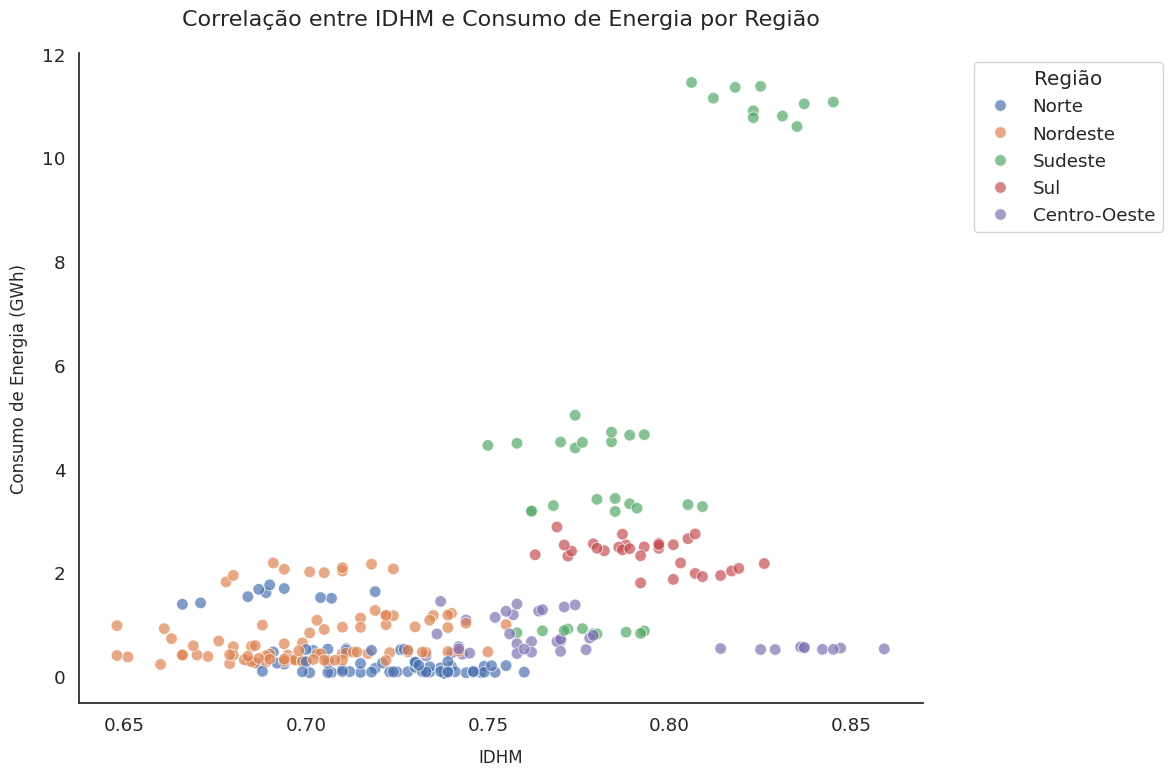

In [359]:
# Configuramos o estilo do seaborn para um visual mais minimalista, ajustando o contexto para "notebook"
# e aumentando a escala da fonte para melhorar a legibilidade
sns.set_context("notebook", font_scale=1.2)

# Criamos a figura e o eixo para o gráfico de dispersão
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

# Criamos o gráfico de dispersão para visualizar a relação entre IDHM e consumo de energia
# As cores são diferenciadas por região, utilizando a paleta deep para melhor distinção
sns.scatterplot(data=idhm_consumo_estados, x='idhm', y='gWh', hue='regiao', 
                palette='deep', s=70, alpha=0.7, ax=ax)

# Removemos as bordas superior e direita para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Configuramos o título e os rótulos dos eixos para descrever claramente o que o gráfico representa
plt.title('Correlação entre IDHM e Consumo de Energia por Região', fontsize=16, pad=20)
plt.xlabel('IDHM', fontsize=12, labelpad=10)
plt.ylabel('Consumo de Energia (GWh)', fontsize=12, labelpad=10)

# Formatamos o eixo y para incluir separadores de milhares, facilitando a leitura dos números
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustamos a legenda para posicioná-la fora do gráfico principal, garantindo que não sobreponha dados
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustamos o layout para assegurar que todos os elementos do gráfico fiquem bem posicionados e legíveis
plt.tight_layout()

# Salvamos o gráfico em um arquivo e o exibimos na tela para visualização
plt.savefig('../imagens/idhm_consumo_dispersao.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Podemos notar um agrupamento da região Sudeste com alto consumo e um alto idh, seguida da região Sul, entretanto há um agrupamento da região Centro-Oeste que apresenta um IDH similar ao da região Sudeste, porém consumindo muito menos energia. A região Norte e Nordeste apresentam um IDH menor como também consumo.

# Conclusão

Esse foi um desafio extenso, com perguntas abertas sobre os dados de consumo e me forçou a pensar bastante nas abordagens que poderia tomar. Para começar, com o EDA, procurei as duplicatas, inclusive com uma função para analisar cada uma delas antes de exluir e na parte de dados ausentes, me deparei com 1/3 de dados ausentes. Da mesma forma procurei entender e fui fazendo análises do que eram esses dados, até perceber que pertenciam a número de consumidores Total e Cativo, que Total abordava todos os outros tipos de consumo e que Cativo era uma parte do total e com isso optei por não excluir e nem imputar valores para esses dados. Essa foi, ao meu ver, a parte mais crítica do desafio e me mostrou a importância de pensar criticamente e de testar hipoteses e seguir com a abordagem.

Como esse notebook é entregue, procurei criar uma estrutura organizada e textos explicativos, nisso recorri a IA para otimizar meus comentários para que ficasse o mais explicativos o possível. Usei versionamento com git para ter sempre um backup e poder voltar a qualquer versão desse código e também abre possibilidade para trabalho colaborativo. Usei IA novamente também para conferir uma estética minimalista aos gráficos e que focassem no dado, com isso eu dei maior atenção ao tratamento, merges e agrupamentos para fazer feature engeneering, obtendo outros dados dos dados principais e decidindo o melhor gráfico para cada uma das perguntas.

Fui atrás de outras bases de dados para ver se podiam trazer mais insights para a base principal. Gostaria de usar uma base de temperaturas, mas a maioria eram por cidades e como a nossa base é por estado não seria adequado correlacionar temperatura e consumo tendo de um lado o consumo de um estado inteiro e do outro lado de algumas cidades, mas pudemos ao longo das perguntas ver como IDHM e A população geral através dos Sensos feitos pelo IBGE se conversavam com a nossa base de consumo energético. Também destaco os acontecimentos que ocorreram ao longo desses anos como uma narrativa histórica que um gráfico de linhas por si só não fala.

Agradeço ao Professor Leandro Lessa por esse desafio e por sempre incutir o senso crítico, ético e profissional em todo o trabalho de ciência de dados e qualquer outro que fazemos.

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38880 entries, 0 to 38879
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ano                  38880 non-null  int64  
 1   mes                  38880 non-null  int64  
 2   sigla_uf             38880 non-null  object 
 3   tipo_consumo         38880 non-null  object 
 4   numero_consumidores  25920 non-null  float64
 5   consumo              38880 non-null  int64  
 6   gWh                  38880 non-null  float64
 7   estado               38880 non-null  object 
 8   regiao               38880 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 2.7+ MB
